 # Electoral Bonds Analysis

### Importing the libraries

In [123]:
# Importing the libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# Wordcloud
from wordcloud import WordCloud
import seaborn as sns 
sns.set_theme(style="whitegrid")
sns.dark_palette((20, 60, 50), input="husl")
# import interactive libraries
import ipywidgets
# library to create sankey charts.
from pySankey.sankey import sankey 
# Library to ignore warning 
import warnings                     # enable this once the code is finalized.
warnings.filterwarnings("ignore")
# Os library is imported to work with files 
import os 

##### Setting the row and column count.

In [124]:
# Set display.max_rows to increase the row limit
pd.set_option('display.max_rows', 100)  # Change 100 to the desired row limit

# Set display.max_columns to increase the column limit
pd.set_option('display.max_columns', 50)  # Change 50 to the desired column limit

### Importing the data: 

- Here we are importing the data about the donors and recivers. 

In [125]:
# Importing donors data as a dataframe: 
donors_df = pd.read_csv("RawData/donor_data.csv")

In [126]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,PayTeller
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230


In [127]:
# Importing political parties received amt data
receiver_df = pd.read_csv("RawData/receiver_data.csv")

### The Bank codes details have been extracted from this website: 

> All the bank banches don't have the authority to issue electoral bonds only few branches of SBI bank can issue them and this table contains the details of that banks and based on the branch code we can connect to the reciver and donor data. 

- [Link](https://pib.gov.in/Pressreleaseshare.aspx?PRID=1566604)

In [128]:
# Importing bank details.
bankdata_df = pd.read_excel("RawData/bank_data.xlsx")

### Peeking into bank data

In [129]:
bankdata_df.head(2)

,Sl. No.,State,Name Of The Branch & Address,Branch Code No.,Branch City
0,1,Delhi,"New Delhi Main Branch,11, Parliament Street, N...",691,New Delhi
1,2,"Haryana, Punjab and Chandigarh","Chandigarh Main Branch,SCO 43-48, Banking Squa...",628,Chandigarh


In [130]:
bankdata_df.columns

Index(['Sl. No.', 'State', 'Name Of The Branch & Address', 'Branch Code No.',
       'Branch City'],
      dtype='object')

In [131]:
bankdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Sl. No.                       29 non-null     int64 
 1   State                         29 non-null     object
 2   Name Of The Branch & Address  29 non-null     object
 3   Branch Code No.               29 non-null     int64 
 4   Branch City                   29 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.3+ KB


In [132]:
bankdata_df['Branch Code No.'].count()

print(f"There are total 29 banks who can issues electoral bonds.")

There are total 29 banks who can issues electoral bonds.


> There are only 29 Banks who can issue electoral bonds

> Address is of not important or we don't have any plans to use it in the analysis. 
>I am removing the column so that my dataframe is slick and my joins will be concise.

In [133]:
# Drop Adress column bankdata
bankdata_df.drop('Name Of The Branch & Address',axis=1,inplace=True)

In [134]:
bankdata_df['State'] = bankdata_df['State'].str.strip()
bankdata_df['Branch City'] = bankdata_df['Branch City'].str.strip()

In [135]:
bankdata_df.head(2)

,Sl. No.,State,Branch Code No.,Branch City
0,1,Delhi,691,New Delhi
1,2,"Haryana, Punjab and Chandigarh",628,Chandigarh


In [136]:
bankdata_df.columns

Index(['Sl. No.', 'State', 'Branch Code No.', 'Branch City'], dtype='object')

In [137]:
bankdata_df.drop(['Sl. No.'],axis=1,inplace=True)

In [138]:
bankdata_df.head()

,State,Branch Code No.,Branch City
0,Delhi,691,New Delhi
1,"Haryana, Punjab and Chandigarh",628,Chandigarh
2,HimachalPradesh,718,Shimla
3,Jammu andKashmir,2295,Srinagar
4,Uttarakhand,630,Dehradun


### Looking into donors data setting data types

In [139]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,PayTeller
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230


### Some of the names in the purchaser columns are spelled wrongly and same company has bought bonds under different names after due diligince some of the names are changed showed like below.   

|Old Purchaser Name                                             |Replaced Purchaser Name                            |
|---------------------------------------------------------------|---------------------------------------------------|
|'AASHMAN ENERGY PRIVATE LIMITED'                               |'AASHMAN ENERGY PRIVATE LIMITED'                   |
|'AASHMAN ENERGY PVT LTD'                                       |'AASHMAN ENERGY PRIVATE LIMITED'                   |
|'ACHINTYA SOLAR POWER PRIVATE LIMITED'                         |'ACHINTYA SOLAR POWER PRIVATE LIMITED'             |
|'ACHINTYA SOLAR POWER PVT LTD'                                 |'ACHINTYA SOLAR POWER PRIVATE LIMITED'             |
|'APCO INFRATECH PRIVATE LIMITED'                               |'APCO INFRATECH PRIVATE LIMITED'                   |
|'APCO INFRATECH PRIVATE LTD'                                   |'APCO INFRATECH PRIVATE LIMITED'                   |
|'APCO INFRATECH PVT LTD FORMERLY AP'                           |'APCO INFRATECH PRIVATE LIMITED'                   |
|'ASKUS LOGISTICS PRIV'                                         |'ASKUS LOGISTICS PRIVATE LIMITED'                  |
|'ASKUS LOGISTICS PRIVATE LIMITED'                              |'ASKUS LOGISTICS PRIVATE LIMITED'                  |
|'ASKUS LOGISTICS PVT LTD'                                      |'ASKUS LOGISTICS PRIVATE LIMITED'                  |
|'AUROBINDO PHARMA LIMITED'                                     |'AUROBINDO PHARMA LIMITED'                         |
|'AUROBINDO PHARMA LTD'                                         |'AUROBINDO PHARMA LIMITED'                         |
|'AVEES TRADING & FINANCE PVT LTD'                              |'AVEES TRADING AND FINANCE PVT LTD'                |
|'AVEES TRADING AND FINANCE PVT LTD'                            |'AVEES TRADING AND FINANCE PVT LTD'                |
|'AVEES TRADING FINANCE PVT LTD'                                |'AVEES TRADING AND FINANCE PVT LTD'                |
|'BALU IRON & STEEL COMPANY'                                    |'BALU IRON AND STEEL COMPANY'                      |
|'BALU IRON AND STEEL COMPANY'                                  |'BALU IRON AND STEEL COMPANY'                      |
|'BESSEGGEN INFOTECH LLP'                                       |'BESSEGGEN INFOTECH LLP'                           |
|'BESSEGGENINFOTECHLLP'                                         |'BESSEGGEN INFOTECH LLP'                           |
|'BHARTI AIRTEL LIMITED'                                        |'BHARTI AIRTEL LIMITED'                            |
|'BHARTI AIRTEL LIMITEDAIRTEL CURRE NT AC-GCO'                  |'BHARTI AIRTEL LIMITED'                            |
|'CASTAMET WORKS'                                               |'CASTAMET WORKS PRIVATE LIMITED'                   |
|'CASTAMET WORKS PRIVATE LIMITED'                               |'CASTAMET WORKS PRIVATE LIMITED'                   |
|'CHOWGLE AND COMPANY PVT LTD'                                  |'CHOWGULE AND COMPANY PVT LTD'                     |
|'CHOWGULE AND COMPANY PVT LTD'                                 |'CHOWGULE AND COMPANY PVT LTD'                     |
|'CIPLA LIMITED'                                                |'CIPLA LIMITED'                                    |
|'CIPLA LTD'                                                    |'CIPLA LIMITED'                                    |
|'COMFORT TRIMS PRIVATE LIMITED'                                |'COMFORT TRIMS PRIVATE LIMITED'                    |
|'COMFORT TRIMS PRIVATE LIMITED DIVIS'                          |'COMFORT TRIMS PRIVATE LIMITED'                    |
|'CROCHET TRADE AND INVESTMENT PVT L'                           |'CROCHET TRADE AND INVESTMENT PVT '                |
|'CROCHET TRADE AND INVESTMENT PVT LT'                          |'CROCHET TRADE AND INVESTMENT PVT '                |
|'D S ENGINEERING WORKS LLP'                                    |'D S ENGINEERING WORKSHOP LLP'                     |
|'D S ENGINEERING WORKSHOP LLP'                                 |'D S ENGINEERING WORKSHOP LLP'                     |
|'DASAMI LAB PRIVATE LIMITED (FORMERLY HEL IUS LAB PVT LTD)'    |'DASAMI LAB PRIVATE LTD'                           |
|'DASAMI LAB PRIVATE LTD'                                       |'DASAMI LAB PRIVATE LTD'                           |
|'DCM SHRIRAM LIMITED'                                          |'DCM SHRIRAM LIMITED'                              |
|'DCM SHRIRAM LTD'                                              |'DCM SHRIRAM LIMITED'                              |
|'DEMPO IND PVT LTD NAVHIND PAPERSAND PUB'                      |'DEMPO INDUSTRIES PVT LTD'                         |
|'DEMPO INDUSTRIES PVT LTD'                                     |'DEMPO INDUSTRIES PVT LTD'                         |
|'DERIVE TRADING AND RESORTS PRIVATE LIMIT'                     |'DERIVE TRADING AND RESORTS PRIVATE LIMITED'       |
|'DERIVE TRADING AND RESORTS PRIVATE LIMITED'                   |'DERIVE TRADING AND RESORTS PRIVATE LIMITED'       |
|'DIVYESH POWER PRIVATE LIMITED'                                |'DIVYESH POWER PRIVATE LIMITED'                    |
|'DIVYESH POWER PVT LTD'                                        |'DIVYESH POWER PRIVATE LIMITED'                    |
|'DR REDDYS LABORATORIES LIMITED'                               |'DR REDDYS LABORATORIES LIMITED'                   |
|'DR.REDDY'S LABORATORIES LTD'                                  |'DR REDDYS LABORATORIES LIMITED'                   |
|'ELENA RENEWABLE ENERGY PRIVATE LIMITED'                       |'ELENA RENEWABLE ENERGY PRIVATE LIMITED'           |
|'ELENA RENEWABLE ENERGY PVT LTD'                               |'ELENA RENEWABLE ENERGY PRIVATE LIMITED'           |
|'FUTURE GAMING AND HOTEL SERVICES PR'                          |'FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED' |
|'FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED'             |'FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED' |
|'FUTURE GAMING AND HOTEL SERVICES PVT LTD'                     |'FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED' |
|'GENUS POWER'                                                  |'GENUS POWER INFRASTRUCTURES LIMITED'              |
|'GENUS POWER INFRASTRUCTURES LIMITED'                          |'GENUS POWER INFRASTRUCTURES LIMITED'              |
|'GENUS POWER INFRASTRUCTURES LTD'                              |'GENUS POWER INFRASTRUCTURES LIMITED'              |
|'GOODLUCK INDIA LIMITED'                                       |'GOODLUCK INDIA LIMITED'                           |
|'GOODLUCK INDIA LTD'                                           |'GOODLUCK INDIA LIMITED'                           |
|'HINDYS LAB PRIVATE LTD'                                       |'HINDYS LAB PRIVATE LTD'                           |
|'HINDYS LAB PVT. LTD. (PREVIOUSLY HIND LI FE SCIENCES PVT LTD)'|'HINDYS LAB PRIVATE LTD'                           |
|'HONOUR LAB LIMITED'                                           |'HONOUR LAB LIMITED'                               |
|'HONOUR LAB LTD'                                               |'HONOUR LAB LIMITED'                               |
|'INORBIT MALLS INDIA PRIVATE LIMIT'                            |'INORBIT MALLS INDIA PRIVATE LIMITED'              |
|'INORBIT MALLS INDIA PRIVATE LIMITED'                          |'INORBIT MALLS INDIA PRIVATE LIMITED'              |
|'INTERGLOBE AIR TRANSPORT LIMITED'                             |'INTERGLOBE AIR TRANSPORT LIMITED'                 |
|'INTERGLOBE AVIATION LIMITED'                                  |'INTERGLOBE AIR TRANSPORT LIMITED'                 |
|'J K CEMENT LIMITED'                                           |'J K CEMENT LIMITED'                               |
|'J K CEMENT LTD.'                                              |'J K CEMENT LIMITED'                               |
|'J.K.CEMENT LTD.'                                              |'J K CEMENT LIMITED'                               |
|'JAI SUSPENSION SYSTEMS L L P'                                 |'JAI SUSPENSION SYSTEMS LLP'                       |
|'JAI SUSPENSION SYSTEMS LLP'                                   |'JAI SUSPENSION SYSTEMS LLP'                       |
|'LAXMI INDUSTRIAL BOTTLING PLAN'                               |'LAXMI INDUSTRIAL BOTTLING PLANT'                  |
|'LAXMI INDUSTRIAL BOTTLING PLANT'                              |'LAXMI INDUSTRIAL BOTTLING PLANT'                  |
|'MADHYA PRADESH WASTE MANAGEMENT PR'                           |'MADHYA PRADESH WASTE MANAGEMENT'                  |
|'MADHYA PRADESH WASTE MANAGEMENT PRI'                          |'MADHYA PRADESH WASTE MANAGEMENT'                  |
|'MEGHA ENGINEERING & INFRASTRUCTURES LIMITED'                  |'MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED'    |
|'MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED'               |'MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED'    |
|'MEGHA ENGINEERING AND INFRASTRUCTURES LTD'                    |'MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED'    |
|'MICRO LABS LIMITED'                                           |'MICRO LABS LIMITED'                               |
|'MICRO LABS LTD'                                               |'MICRO LABS LIMITED'                               |
|'MKK METAL SECTIONS P LTD'                                     |'MKK METAL SECTIONS PVT LTD'                       |
|'MKK METAL SECTIONS PVT LTD'                                   |'MKK METAL SECTIONS PVT LTD'                       |
|'MODERN ROAD MAKERS PVT LTD'                                   |'MODERN ROAD MAKERS PVT LTD'                       |
|'MODERN ROAD MAKERS PVT. LTD.'                                 |'MODERN ROAD MAKERS PVT LTD'                       |
|'MOHIT MINERALS LIMITED'                                       |'MOHIT MINERALS LIMITED'                           |
|'MOHIT MINERALS LTD'                                           |'MOHIT MINERALS LIMITED'                           |
|'MY HOME INFRASTRUCTURES PRIVATE LI'                           |'MY HOME INFRASTRUCTURES PVT LTD '                 |
|'MY HOME INFRASTRUCTURES PVT LTD MY'                           |'MY HOME INFRASTRUCTURES PVT LTD '                 |
|'MYTRAH ENERGY INDIA PRIVATE LIMITED'                          |'MYTRAH ENERGY INDIA PRIVATE LIMITED'              |
|'MYTRAH ENERGY(INDIA) PRIVATE LIMITED'                         |'MYTRAH ENERGY INDIA PRIVATE LIMITED'              |
|'NATCO PHARMA LIMITED'                                         |'NATCO PHARMA LIMITED'                             |
|'NATCO PHARMA LTD'                                             |'NATCO PHARMA LIMITED'                             |
|'NAVAYUGA ENGINEERING CO LTD'                                  |'NAVAYUGA ENGINEERING COMPANY LIMITED'             |
|'NAVAYUGA ENGINEERING COMPANY LIMITED'                         |'NAVAYUGA ENGINEERING COMPANY LIMITED'             |
|'NSL SEZ HYDERABAD PRIVATE LIMITED'                            |'NSL SEZ HYDERABAD PRIVATE LIMITED'                |
|'NSL SEZ(HYDERABAD) PRIVATE LIMITED'                           |'NSL SEZ HYDERABAD PRIVATE LIMITED'                |
|'NUVOCO VISTAS CORP. LTD'                                      |'NUVOCO VISTAS CORP LTD'                           |
|'NUVOCO VISTAS CORPORATION LTD'                                |'NUVOCO VISTAS CORP LTD'                           |
|'ORISSA METALIKS PVT LIMITED'                                  |'ORISSA METALIKS PRIVATE LIMITED'                  |
|'ORRISA METALIKS PVT LTD'                                      |'ORISSA METALIKS PRIVATE LIMITED'                  |
|'PALM SHELTER ESTATE DEVELOPMENT LL'                           |'PALM SHELTER ESTATE DEVELOPMENT LLP'              |
|'PALM SHELTER ESTATE DEVELOPMENT LLP'                          |'PALM SHELTER ESTATE DEVELOPMENT LLP'              |
|'PENGUIN TRADING & AGENCIES LIMITED'                           |'PENGUIN TRADING AND AGENCIES LIMITED'             |
|'PENGUIN TRADING AND AGENCIES LTD'                             |'PENGUIN TRADING AND AGENCIES LIMITED'             |
|'PHILIPS CARBON BLACK LTD'                                     |'PHILLIPS CARBON BLACK LIMITED'                    |
|'PHILLIPS CARBON BLACK LIMITED'                                |'PHILLIPS CARBON BLACK LIMITED'                    |
|'PLUTO FINANCE PRIVATE LTD'                                    |'PLUTO FINANCE PRIVATE LIMITED'                    |
|'PLUTO FINANCE PRIVATE LTD.'                                   |'PLUTO FINANCE PRIVATE LIMITED'                    |
|'PRARAMBH SECURITIES PVT LTDOWN A/C'                           |'PRARAMBH SECURITIES PVT LTD'                      |
|'PRARAMBH SECURITIES PVT LTDPROPRIET'                          |'PRARAMBH SECURITIES PVT LTD'                      |
|'PROCURE ADVISORY SERVICES PRIVATE L'                          |'PROCURE ADVISORY SERVICES PRIVATE LTD'            |
|'PROCURE ADVISORY SERVICES PRIVATE LTD'                        |'PROCURE ADVISORY SERVICES PRIVATE LTD'            |
|'R.S.BROTHERS RETAIL INDIA PRIVATE LIMITE D'                   |'R.S.BROTHERS RETAIL INDIA PRIVATE LIMITED'        |
|'R.S.BROTHERS RETIAL INDIA PVT LTD'                            |'R.S.BROTHERS RETAIL INDIA PRIVATE LIMITED'        |
|'RAMESH AGARWAL C S BOTTLING PL'                               |'RAMESH AGARWAL C S BOTTLING PLANT'                |
|'RAMESH AGARWAL C S BOTTLING PLANT'                            |'RAMESH AGARWAL C S BOTTLING PLANT'                |
|'RANISATI MERCANTILES PVT LTD'                                 |'RANISATI MERCANTILES PVT LTD'                     |
|'RANISATI MERCANTILES PVT. LTD.'                               |'RANISATI MERCANTILES PVT LTD'                     |
|'RIPLEY & CO STEVDORING & HANDLING PVT LT D'                   |'RIPLEY AND CO STEVEDORING AND HANDLING PVT LTD'   |
|'RIPLEY AND CO. STEVEDORING & HANDLING PVT LTD'                |'RIPLEY AND CO STEVEDORING AND HANDLING PVT LTD'   |
|'ROSHNI DEALMARK PRIVATE LIMITED'                              |'ROSHNI DEALMARK PRIVATE LIMITED'                  |
|'ROSHNI DEALMARK PRIVATE LTD'                                  |'ROSHNI DEALMARK PRIVATE LIMITED'                  |
|'S K TRADERS'                                                  |'S K TRADING CO.'                                  |
|'S K TRADING CO.'                                              |'S K TRADING CO.'                                  |
|'SELMAR LAB PRIVATE LIMITED'                                   |'SELMAR LAB PRIVATE LIMITED'                       |
|'SELMAR LAB PRIVATE LTD'                                       |'SELMAR LAB PRIVATE LIMITED'                       |
|'SENGUPTA AND SENGUPTA PRIVATE LIMIT'                          |'SENGUPTA AND SENGUPTA PRIVATE LIMIT'              |
|'SENGUPTA AND SENGUPTA PVT LTD'                                |'SENGUPTA AND SENGUPTA PRIVATE LIMIT'              |
|'SHREE CEMENT LIMITED'                                         |'SHREE CEMENT LIMITED'                             |
|'SHREE CEMENT LTD'                                             |'SHREE CEMENT LIMITED'                             |
|'SKEIRON RENEWABLE ENERGY AMIDYALA P'                          |'SKEIRON RENEWABLE ENERGY AMIDYALA PRIVATE LIMITED'|
|'SKEIRON RENEWABLE ENERGY AMIDYALA PRIVATE LIMITED'            |'SKEIRON RENEWABLE ENERGY AMIDYALA PRIVATE LIMITED'|
|'SOM DISTILERIES PRIVATE LTD'                                  |'SOM DISTILLERIES PVT LTD'                         |
|'SOM DISTILLERIES BREWERIES LIMITED'                           |'SOM DISTILLERIES PVT LTD'                         |
|'SOM DISTILLERIES PVT LTD'                                     |'SOM DISTILLERIES PVT LTD'                         |
|'SPECO INFRASTRUCTURE'                                         |'SPECO INFRASTRUCTURES'                            |
|'SPECO INFRASTRUCTURES'                                        |'SPECO INFRASTRUCTURES'                            |
|'SRI SIDDHARTH INFRATECH & SERVICES(I) PVT LTD'                |'SRI SIDDHARTH INFRATECH AND SERVICES PVT LTD'     |
|'SRI SIDDHARTH INFRATECH AND SERVICES I P'                     |'SRI SIDDHARTH INFRATECH AND SERVICES PVT LTD'     |
|'SUN PHARMA LABORATORIES LIMTED'                               |'SUN PHARMA LABORATORIES LIMTED'                   |
|'SUN PHARMA LABORATORIES LTD'                                  |'SUN PHARMA LABORATORIES LIMTED'                   |
|'THRIVENI EARTH MOVERS PVT LTD'                                |'THRIVENI EARTH MOVERS PVT LTD'                    |
|'THRIVENI EARTHMOVERS PVT LTD'                                 |'THRIVENI EARTH MOVERS PVT LTD'                    |
|'TORRENT PHARMACEUTICALS LIMITED'                              |'TORRENT PHARMACEUTICALS LIMITED'                  |
|'TORRENT PHARMACEUTICALS LTD'                                  |'TORRENT PHARMACEUTICALS LIMITED'                  |
|'TORRENT POWER LIMITED'                                        |'TORRENT POWER LIMITED'                            |
|'TORRENT POWER LTD'                                            |'TORRENT POWER LIMITED'                            |
|'TRANSWAYS EXIM PRIVATE LIMITED'                               |'TRANSWAYS EXIM PRIVATE LIMITED'                   |
|'TRANSWAYS EXIM PRIVATE LTD'                                   |'TRANSWAYS EXIM PRIVATE LIMITED'                   |
|'TRANSWAYS EXIM PVT LTD'                                       |'TRANSWAYS EXIM PRIVATE LIMITED'                   |
|'TRIDENT LIMITED'                                              |'TRIDENT LIMITED'                                  |
|'TRIDENT LIMITED {FORMERLY ABHISHEK INDUS TRIES LIMITED}'      |'TRIDENT LIMITED'                                  |
|'ULTRA TECH CEMENT LIMITED'                                    |'ULTRA TECH CEMENT LIMITED'                        |
|'ULTRATECHCEMENTSLTD'                                          |'ULTRA TECH CEMENT LIMITED'                        |
|'UTKAL ALUMINA INTERNATIONAL LIMITED'                          |'UTKAL ALUMINA INTERNATIONAL LIMITED'              |
|'UTKAL ALUMINA INTERNATIONAL LTD'                              |'UTKAL ALUMINA INTERNATIONAL LIMITED'              |
|'VARAS INTERNATIONAL PRIVATE LIMITED'                          |'VARAS INTERNATIONAL PRIVATE LIMITED'              |
|'VARAS INTERNATIONAL PVT LTD'                                  |'VARAS INTERNATIONAL PRIVATE LIMITED'              |
|'VARDHMAN TEXTILES LIMITED'                                    |'VARDHMAN TEXTILES LIMITED'                        |
|'VARDHMAN TEXTILES LTD'                                        |'VARDHMAN TEXTILES LIMITED'                        |
|'VEDANTA LIMITED'                                              |'VEDANTA LIMITED'                                  |
|'VEDANTA LTD'                                                  |'VEDANTA LIMITED'                                  |
|'WARORA CHANDRAPUR BALLARPUR TOLLRO'                           |'WARORA CHANDRAPUR BALLARPUR TOLL ROAD'            |
|'WARORA CHANDRAPUR BALLARPUR TOLLROA'                          |'WARORA CHANDRAPUR BALLARPUR TOLL ROAD'            |
|'WELSPUN CORP LIMITED'                                         |'WELSPUN CORP LIMITED'                             |
|'WELSPUN CORP LTD'                                             |'WELSPUN CORP LIMITED'                             |
|'ZUVAN ENERGY PRIVATE LIMITED'                                 |'ZUVAN ENERGY PRIVATE LIMITED'                     |
|'ZUVAN ENERGY PVT LTD'                                         |'ZUVAN ENERGY PRIVATE LIMITED'                     |
|'GREENKO RAYALA WIND POWER PVT LTD'                            |'GREENKO RAYALA WIND POWER PRIVATE LIMITED'        |
|'GREENKO RAYALA WIND POWER PRIVATE LIMITE D'                   |'GREENKO RAYALA WIND POWER PRIVATE LIMITED'        |

In [140]:
# replacing the purchaser names 
donors_df['Purchaser'].replace('AASHMAN ENERGY PRIVATE LIMITED','AASHMAN ENERGY PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('AASHMAN ENERGY PVT LTD','AASHMAN ENERGY PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ACHINTYA SOLAR POWER PRIVATE LIMITED','ACHINTYA SOLAR POWER PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ACHINTYA SOLAR POWER PVT LTD','ACHINTYA SOLAR POWER PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('APCO INFRATECH PRIVATE LIMITED','APCO INFRATECH PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('APCO INFRATECH PRIVATE LTD','APCO INFRATECH PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('APCO INFRATECH PVT LTD FORMERLY AP','APCO INFRATECH PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ASKUS LOGISTICS PRIV','ASKUS LOGISTICS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ASKUS LOGISTICS PRIVATE LIMITED','ASKUS LOGISTICS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ASKUS LOGISTICS PVT LTD','ASKUS LOGISTICS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('AUROBINDO PHARMA LIMITED','AUROBINDO PHARMA LIMITED',inplace=True)
donors_df['Purchaser'].replace('AUROBINDO PHARMA LTD','AUROBINDO PHARMA LIMITED',inplace=True)
donors_df['Purchaser'].replace('AVEES TRADING & FINANCE PVT LTD','AVEES TRADING AND FINANCE PVT LTD',inplace=True)
donors_df['Purchaser'].replace('AVEES TRADING AND FINANCE PVT LTD','AVEES TRADING AND FINANCE PVT LTD',inplace=True)
donors_df['Purchaser'].replace('AVEES TRADING FINANCE PVT LTD','AVEES TRADING AND FINANCE PVT LTD',inplace=True)
donors_df['Purchaser'].replace('BALU IRON & STEEL COMPANY','BALU IRON AND STEEL COMPANY',inplace=True)
donors_df['Purchaser'].replace('BALU IRON AND STEEL COMPANY','BALU IRON AND STEEL COMPANY',inplace=True)
donors_df['Purchaser'].replace('BESSEGGEN INFOTECH LLP','BESSEGGEN INFOTECH LLP',inplace=True)
donors_df['Purchaser'].replace('BESSEGGENINFOTECHLLP','BESSEGGEN INFOTECH LLP',inplace=True)
donors_df['Purchaser'].replace('BHARTI AIRTEL LIMITED','BHARTI AIRTEL LIMITED',inplace=True)
donors_df['Purchaser'].replace('BHARTI AIRTEL LIMITEDAIRTEL CURRE NT AC-GCO','BHARTI AIRTEL LIMITED',inplace=True)
donors_df['Purchaser'].replace('CASTAMET WORKS','CASTAMET WORKS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('CASTAMET WORKS PRIVATE LIMITED','CASTAMET WORKS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('CHOWGLE AND COMPANY PVT LTD','CHOWGULE AND COMPANY PVT LTD',inplace=True)
donors_df['Purchaser'].replace('CHOWGULE AND COMPANY PVT LTD','CHOWGULE AND COMPANY PVT LTD',inplace=True)
donors_df['Purchaser'].replace('CIPLA LIMITED','CIPLA LIMITED',inplace=True)
donors_df['Purchaser'].replace('CIPLA LTD','CIPLA LIMITED',inplace=True)
donors_df['Purchaser'].replace('COMFORT TRIMS PRIVATE LIMITED','COMFORT TRIMS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('COMFORT TRIMS PRIVATE LIMITED DIVIS','COMFORT TRIMS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('CROCHET TRADE AND INVESTMENT PVT L','CROCHET TRADE AND INVESTMENT PVT ',inplace=True)
donors_df['Purchaser'].replace('CROCHET TRADE AND INVESTMENT PVT LT','CROCHET TRADE AND INVESTMENT PVT ',inplace=True)
donors_df['Purchaser'].replace('D S ENGINEERING WORKS LLP','D S ENGINEERING WORKSHOP LLP',inplace=True)
donors_df['Purchaser'].replace('D S ENGINEERING WORKSHOP LLP','D S ENGINEERING WORKSHOP LLP',inplace=True)
donors_df['Purchaser'].replace('DASAMI LAB PRIVATE LIMITED (FORMERLY HEL IUS LAB PVT LTD)','DASAMI LAB PRIVATE LTD',inplace=True)
donors_df['Purchaser'].replace('DASAMI LAB PRIVATE LTD','DASAMI LAB PRIVATE LTD',inplace=True)
donors_df['Purchaser'].replace('DCM SHRIRAM LIMITED','DCM SHRIRAM LIMITED',inplace=True)
donors_df['Purchaser'].replace('DCM SHRIRAM LTD','DCM SHRIRAM LIMITED',inplace=True)
donors_df['Purchaser'].replace('DEMPO IND PVT LTD NAVHIND PAPERSAND PUB','DEMPO INDUSTRIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('DEMPO INDUSTRIES PVT LTD','DEMPO INDUSTRIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('DERIVE TRADING AND RESORTS PRIVATE LIMIT','DERIVE TRADING AND RESORTS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('DERIVE TRADING AND RESORTS PRIVATE LIMITED','DERIVE TRADING AND RESORTS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('DIVYESH POWER PRIVATE LIMITED','DIVYESH POWER PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('DIVYESH POWER PVT LTD','DIVYESH POWER PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('DR REDDYS LABORATORIES LIMITED','DR REDDYS LABORATORIES LIMITED',inplace=True)
donors_df['Purchaser'].replace("DR.REDDY'S LABORATORIES LTD",'DR REDDYS LABORATORIES LIMITED',inplace=True)
donors_df['Purchaser'].replace('ELENA RENEWABLE ENERGY PRIVATE LIMITED','ELENA RENEWABLE ENERGY PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ELENA RENEWABLE ENERGY PVT LTD','ELENA RENEWABLE ENERGY PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('FUTURE GAMING AND HOTEL SERVICES PR','FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED','FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('FUTURE GAMING AND HOTEL SERVICES PVT LTD','FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('GENUS POWER','GENUS POWER INFRASTRUCTURES LIMITED',inplace=True)
donors_df['Purchaser'].replace('GENUS POWER INFRASTRUCTURES LIMITED','GENUS POWER INFRASTRUCTURES LIMITED',inplace=True)
donors_df['Purchaser'].replace('GENUS POWER INFRASTRUCTURES LTD','GENUS POWER INFRASTRUCTURES LIMITED',inplace=True)
donors_df['Purchaser'].replace('GOODLUCK INDIA LIMITED','GOODLUCK INDIA LIMITED',inplace=True)
donors_df['Purchaser'].replace('GOODLUCK INDIA LTD','GOODLUCK INDIA LIMITED',inplace=True)
donors_df['Purchaser'].replace('HINDYS LAB PRIVATE LTD','HINDYS LAB PRIVATE LTD',inplace=True)
donors_df['Purchaser'].replace('HINDYS LAB PVT. LTD. (PREVIOUSLY HIND LI FE SCIENCES PVT LTD)','HINDYS LAB PRIVATE LTD',inplace=True)
donors_df['Purchaser'].replace('HONOUR LAB LIMITED','HONOUR LAB LIMITED',inplace=True)
donors_df['Purchaser'].replace('HONOUR LAB LTD','HONOUR LAB LIMITED',inplace=True)
donors_df['Purchaser'].replace('INORBIT MALLS INDIA PRIVATE LIMIT','INORBIT MALLS INDIA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('INORBIT MALLS INDIA PRIVATE LIMITED','INORBIT MALLS INDIA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('INTERGLOBE AIR TRANSPORT LIMITED','INTERGLOBE AIR TRANSPORT LIMITED',inplace=True)
donors_df['Purchaser'].replace('INTERGLOBE AVIATION LIMITED','INTERGLOBE AIR TRANSPORT LIMITED',inplace=True)
donors_df['Purchaser'].replace('J K CEMENT LIMITED','J K CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('J K CEMENT LTD.','J K CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('J.K.CEMENT LTD.','J K CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('JAI SUSPENSION SYSTEMS L L P','JAI SUSPENSION SYSTEMS LLP',inplace=True)
donors_df['Purchaser'].replace('JAI SUSPENSION SYSTEMS LLP','JAI SUSPENSION SYSTEMS LLP',inplace=True)
donors_df['Purchaser'].replace('LAXMI INDUSTRIAL BOTTLING PLAN','LAXMI INDUSTRIAL BOTTLING PLANT',inplace=True)
donors_df['Purchaser'].replace('LAXMI INDUSTRIAL BOTTLING PLANT','LAXMI INDUSTRIAL BOTTLING PLANT',inplace=True)
donors_df['Purchaser'].replace('MADHYA PRADESH WASTE MANAGEMENT PR','MADHYA PRADESH WASTE MANAGEMENT',inplace=True)
donors_df['Purchaser'].replace('MADHYA PRADESH WASTE MANAGEMENT PRI','MADHYA PRADESH WASTE MANAGEMENT',inplace=True)
donors_df['Purchaser'].replace('MEGHA ENGINEERING & INFRASTRUCTURES LIMITED','MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED',inplace=True)
donors_df['Purchaser'].replace('MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED','MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED',inplace=True)
donors_df['Purchaser'].replace('MEGHA ENGINEERING AND INFRASTRUCTURES LTD','MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED',inplace=True)
donors_df['Purchaser'].replace('MICRO LABS LIMITED','MICRO LABS LIMITED',inplace=True)
donors_df['Purchaser'].replace('MICRO LABS LTD','MICRO LABS LIMITED',inplace=True)
donors_df['Purchaser'].replace('MKK METAL SECTIONS P LTD','MKK METAL SECTIONS PVT LTD',inplace=True)
donors_df['Purchaser'].replace('MKK METAL SECTIONS PVT LTD','MKK METAL SECTIONS PVT LTD',inplace=True)
donors_df['Purchaser'].replace('MODERN ROAD MAKERS PVT LTD','MODERN ROAD MAKERS PVT LTD',inplace=True)
donors_df['Purchaser'].replace('MODERN ROAD MAKERS PVT. LTD.','MODERN ROAD MAKERS PVT LTD',inplace=True)
donors_df['Purchaser'].replace('MOHIT MINERALS LIMITED','MOHIT MINERALS LIMITED',inplace=True)
donors_df['Purchaser'].replace('MOHIT MINERALS LTD','MOHIT MINERALS LIMITED',inplace=True)
donors_df['Purchaser'].replace('MY HOME INFRASTRUCTURES PRIVATE LI','MY HOME INFRASTRUCTURES PVT LTD ',inplace=True)
donors_df['Purchaser'].replace('MY HOME INFRASTRUCTURES PVT LTD MY','MY HOME INFRASTRUCTURES PVT LTD ',inplace=True)
donors_df['Purchaser'].replace('MYTRAH ENERGY INDIA PRIVATE LIMITED','MYTRAH ENERGY INDIA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('MYTRAH ENERGY(INDIA) PRIVATE LIMITED','MYTRAH ENERGY INDIA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('NATCO PHARMA LIMITED','NATCO PHARMA LIMITED',inplace=True)
donors_df['Purchaser'].replace('NATCO PHARMA LTD','NATCO PHARMA LIMITED',inplace=True)
donors_df['Purchaser'].replace('NAVAYUGA ENGINEERING CO LTD','NAVAYUGA ENGINEERING COMPANY LIMITED',inplace=True)
donors_df['Purchaser'].replace('NAVAYUGA ENGINEERING COMPANY LIMITED','NAVAYUGA ENGINEERING COMPANY LIMITED',inplace=True)
donors_df['Purchaser'].replace('NSL SEZ HYDERABAD PRIVATE LIMITED','NSL SEZ HYDERABAD PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('NSL SEZ(HYDERABAD) PRIVATE LIMITED','NSL SEZ HYDERABAD PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('NUVOCO VISTAS CORP. LTD','NUVOCO VISTAS CORP LTD',inplace=True)
donors_df['Purchaser'].replace('NUVOCO VISTAS CORPORATION LTD','NUVOCO VISTAS CORP LTD',inplace=True)
donors_df['Purchaser'].replace('ORISSA METALIKS PVT LIMITED','ORISSA METALIKS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ORRISA METALIKS PVT LTD','ORISSA METALIKS PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('PALM SHELTER ESTATE DEVELOPMENT LL','PALM SHELTER ESTATE DEVELOPMENT LLP',inplace=True)
donors_df['Purchaser'].replace('PALM SHELTER ESTATE DEVELOPMENT LLP','PALM SHELTER ESTATE DEVELOPMENT LLP',inplace=True)
donors_df['Purchaser'].replace('PENGUIN TRADING & AGENCIES LIMITED','PENGUIN TRADING AND AGENCIES LIMITED',inplace=True)
donors_df['Purchaser'].replace('PENGUIN TRADING AND AGENCIES LTD','PENGUIN TRADING AND AGENCIES LIMITED',inplace=True)
donors_df['Purchaser'].replace('PHILIPS CARBON BLACK LTD','PHILLIPS CARBON BLACK LIMITED',inplace=True)
donors_df['Purchaser'].replace('PHILLIPS CARBON BLACK LIMITED','PHILLIPS CARBON BLACK LIMITED',inplace=True)
donors_df['Purchaser'].replace('PLUTO FINANCE PRIVATE LTD','PLUTO FINANCE PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('PLUTO FINANCE PRIVATE LTD.','PLUTO FINANCE PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('PRARAMBH SECURITIES PVT LTDOWN A/C','PRARAMBH SECURITIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('PRARAMBH SECURITIES PVT LTDPROPRIET','PRARAMBH SECURITIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('PROCURE ADVISORY SERVICES PRIVATE L','PROCURE ADVISORY SERVICES PRIVATE LTD',inplace=True)
donors_df['Purchaser'].replace('PROCURE ADVISORY SERVICES PRIVATE LTD','PROCURE ADVISORY SERVICES PRIVATE LTD',inplace=True)
donors_df['Purchaser'].replace('R.S.BROTHERS RETAIL INDIA PRIVATE LIMITE D','R.S.BROTHERS RETAIL INDIA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('R.S.BROTHERS RETIAL INDIA PVT LTD','R.S.BROTHERS RETAIL INDIA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('RAMESH AGARWAL C S BOTTLING PL','RAMESH AGARWAL C S BOTTLING PLANT',inplace=True)
donors_df['Purchaser'].replace('RAMESH AGARWAL C S BOTTLING PLANT','RAMESH AGARWAL C S BOTTLING PLANT',inplace=True)
donors_df['Purchaser'].replace('RANISATI MERCANTILES PVT LTD','RANISATI MERCANTILES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('RANISATI MERCANTILES PVT. LTD.','RANISATI MERCANTILES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('RIPLEY & CO STEVDORING & HANDLING PVT LT D','RIPLEY AND CO STEVEDORING AND HANDLING PVT LTD',inplace=True)
donors_df['Purchaser'].replace('RIPLEY AND CO. STEVEDORING & HANDLING PVT LTD','RIPLEY AND CO STEVEDORING AND HANDLING PVT LTD',inplace=True)
donors_df['Purchaser'].replace('ROSHNI DEALMARK PRIVATE LIMITED','ROSHNI DEALMARK PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ROSHNI DEALMARK PRIVATE LTD','ROSHNI DEALMARK PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('S K TRADERS','S K TRADING CO.',inplace=True)
donors_df['Purchaser'].replace('S K TRADING CO.','S K TRADING CO.',inplace=True)
donors_df['Purchaser'].replace('SELMAR LAB PRIVATE LIMITED','SELMAR LAB PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('SELMAR LAB PRIVATE LTD','SELMAR LAB PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('SENGUPTA AND SENGUPTA PRIVATE LIMIT','SENGUPTA AND SENGUPTA PRIVATE LIMIT',inplace=True)
donors_df['Purchaser'].replace('SENGUPTA AND SENGUPTA PVT LTD','SENGUPTA AND SENGUPTA PRIVATE LIMIT',inplace=True)
donors_df['Purchaser'].replace('SHREE CEMENT LIMITED','SHREE CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('SHREE CEMENT LTD','SHREE CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('SKEIRON RENEWABLE ENERGY AMIDYALA P','SKEIRON RENEWABLE ENERGY AMIDYALA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('SKEIRON RENEWABLE ENERGY AMIDYALA PRIVATE LIMITED','SKEIRON RENEWABLE ENERGY AMIDYALA PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('SOM DISTILERIES PRIVATE LTD','SOM DISTILLERIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('SOM DISTILLERIES BREWERIES LIMITED','SOM DISTILLERIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('SOM DISTILLERIES PVT LTD','SOM DISTILLERIES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('SPECO INFRASTRUCTURE','SPECO INFRASTRUCTURES',inplace=True)
donors_df['Purchaser'].replace('SPECO INFRASTRUCTURES','SPECO INFRASTRUCTURES',inplace=True)
donors_df['Purchaser'].replace('SRI SIDDHARTH INFRATECH & SERVICES(I) PVT LTD','SRI SIDDHARTH INFRATECH AND SERVICES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('SRI SIDDHARTH INFRATECH AND SERVICES I P','SRI SIDDHARTH INFRATECH AND SERVICES PVT LTD',inplace=True)
donors_df['Purchaser'].replace('SUN PHARMA LABORATORIES LIMTED','SUN PHARMA LABORATORIES LIMTED',inplace=True)
donors_df['Purchaser'].replace('SUN PHARMA LABORATORIES LTD','SUN PHARMA LABORATORIES LIMTED',inplace=True)
donors_df['Purchaser'].replace('THRIVENI EARTH MOVERS PVT LTD','THRIVENI EARTH MOVERS PVT LTD',inplace=True)
donors_df['Purchaser'].replace('THRIVENI EARTHMOVERS PVT LTD','THRIVENI EARTH MOVERS PVT LTD',inplace=True)
donors_df['Purchaser'].replace('TORRENT PHARMACEUTICALS LIMITED','TORRENT PHARMACEUTICALS LIMITED',inplace=True)
donors_df['Purchaser'].replace('TORRENT PHARMACEUTICALS LTD','TORRENT PHARMACEUTICALS LIMITED',inplace=True)
donors_df['Purchaser'].replace('TORRENT POWER LIMITED','TORRENT POWER LIMITED',inplace=True)
donors_df['Purchaser'].replace('TORRENT POWER LTD','TORRENT POWER LIMITED',inplace=True)
donors_df['Purchaser'].replace('TRANSWAYS EXIM PRIVATE LIMITED','TRANSWAYS EXIM PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('TRANSWAYS EXIM PRIVATE LTD','TRANSWAYS EXIM PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('TRANSWAYS EXIM PVT LTD','TRANSWAYS EXIM PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('TRIDENT LIMITED','TRIDENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('TRIDENT LIMITED {FORMERLY ABHISHEK INDUS TRIES LIMITED}','TRIDENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('ULTRA TECH CEMENT LIMITED','ULTRA TECH CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('ULTRATECHCEMENTSLTD','ULTRA TECH CEMENT LIMITED',inplace=True)
donors_df['Purchaser'].replace('UTKAL ALUMINA INTERNATIONAL LIMITED','UTKAL ALUMINA INTERNATIONAL LIMITED',inplace=True)
donors_df['Purchaser'].replace('UTKAL ALUMINA INTERNATIONAL LTD','UTKAL ALUMINA INTERNATIONAL LIMITED',inplace=True)
donors_df['Purchaser'].replace('VARAS INTERNATIONAL PRIVATE LIMITED','VARAS INTERNATIONAL PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('VARAS INTERNATIONAL PVT LTD','VARAS INTERNATIONAL PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('VARDHMAN TEXTILES LIMITED','VARDHMAN TEXTILES LIMITED',inplace=True)
donors_df['Purchaser'].replace('VARDHMAN TEXTILES LTD','VARDHMAN TEXTILES LIMITED',inplace=True)
donors_df['Purchaser'].replace('VEDANTA LIMITED','VEDANTA LIMITED',inplace=True)
donors_df['Purchaser'].replace('VEDANTA LTD','VEDANTA LIMITED',inplace=True)
donors_df['Purchaser'].replace('WARORA CHANDRAPUR BALLARPUR TOLLRO','WARORA CHANDRAPUR BALLARPUR TOLL ROAD',inplace=True)
donors_df['Purchaser'].replace('WARORA CHANDRAPUR BALLARPUR TOLLROA','WARORA CHANDRAPUR BALLARPUR TOLL ROAD',inplace=True)
donors_df['Purchaser'].replace('WELSPUN CORP LIMITED','WELSPUN CORP LIMITED',inplace=True)
donors_df['Purchaser'].replace('WELSPUN CORP LTD','WELSPUN CORP LIMITED',inplace=True)
donors_df['Purchaser'].replace('ZUVAN ENERGY PRIVATE LIMITED','ZUVAN ENERGY PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('ZUVAN ENERGY PVT LTD','ZUVAN ENERGY PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('GREENKO RAYALA WIND POWER PRIVATE LIMITE D','GREENKO RAYALA WIND POWER PRIVATE LIMITED',inplace=True)
donors_df['Purchaser'].replace('GREENKO RAYALA WIND POWER PVT LTD','GREENKO RAYALA WIND POWER PRIVATE LIMITED',inplace=True)


In [141]:
donors_df.columns

Index(['SNo', 'Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'Denominations', 'IssueBranchCode',
       'PayTeller'],
      dtype='object')

In [142]:
donors_df.shape

(18871, 11)

In [143]:
donors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18871 entries, 0 to 18870
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SNo              18871 non-null  int64 
 1   Urn              18871 non-null  object
 2   JournalDate      18871 non-null  object
 3   PurchaseDate     18871 non-null  object
 4   ExpiryDate       18871 non-null  object
 5   Purchaser        18871 non-null  object
 6   Prefix           18871 non-null  object
 7   BondNumber       18871 non-null  int64 
 8   Denominations    18871 non-null  int64 
 9   IssueBranchCode  18871 non-null  int64 
 10  PayTeller        18871 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.6+ MB


In [144]:
donors_df['ExpiryDate'] = pd.to_datetime(donors_df['ExpiryDate'])
donors_df['JournalDate'] = pd.to_datetime(donors_df['JournalDate'])
donors_df['PurchaseDate'] = pd.to_datetime(donors_df['PurchaseDate'])

In [145]:
donors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18871 entries, 0 to 18870
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SNo              18871 non-null  int64         
 1   Urn              18871 non-null  object        
 2   JournalDate      18871 non-null  datetime64[ns]
 3   PurchaseDate     18871 non-null  datetime64[ns]
 4   ExpiryDate       18871 non-null  datetime64[ns]
 5   Purchaser        18871 non-null  object        
 6   Prefix           18871 non-null  object        
 7   BondNumber       18871 non-null  int64         
 8   Denominations    18871 non-null  int64         
 9   IssueBranchCode  18871 non-null  int64         
 10  PayTeller        18871 non-null  int64         
dtypes: datetime64[ns](3), int64(5), object(3)
memory usage: 1.6+ MB


In [146]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,PayTeller
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230


In [147]:
# Striping purchaser column --> cleaning the columns
donors_df['Purchaser'] = donors_df['Purchaser'].str.strip()

In [148]:
# Rename the columns to decrease the confusion on the columns names
donors_df.rename(columns={'PayTeller':'IssueTeller'})


,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,IssueTeller
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230
2,3,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11441,1000000,1,5899230
3,4,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,OL,1113,100000,1,5899230
4,5,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,OL,1118,100000,1,5899230
...,...,...,...,...,...,...,...,...,...,...,...
18866,18867,00001202401110000003729,2024-01-11,2024-01-11,2024-01-25,WESTWELL GASES PRIVATE LIMITED,OC,15695,10000000,1,5898161
18867,18868,00001202401110000003729,2024-01-11,2024-01-11,2024-01-25,WESTWELL GASES PRIVATE LIMITED,OC,15693,10000000,1,5898161
18868,18869,00001202401110000003729,2024-01-11,2024-01-11,2024-01-25,WESTWELL GASES PRIVATE LIMITED,OC,15697,10000000,1,5898161
18869,18870,00001202401110000003729,2024-01-11,2024-01-11,2024-01-25,WESTWELL GASES PRIVATE LIMITED,OC,17803,10000000,1,5898161


In [149]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,PayTeller
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230


In [150]:
donors_df = pd.merge(donors_df,
                     bankdata_df, 
                     left_on='IssueBranchCode',
                     right_on='Branch Code No.',
                     how='inner')

In [151]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,PayTeller,State,Branch Code No.,Branch City
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata


In [152]:
donors_df.columns

Index(['SNo', 'Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'Denominations', 'IssueBranchCode', 'PayTeller',
       'State', 'Branch Code No.', 'Branch City'],
      dtype='object')

### Creating a composite key: 

- We are a creating a composite key which is a combination of Prefix and BondNumber which acts as a primary and will be the common column in donor and reciver table.

> The `Prefix` column and `BondNumber` column combination acts as unique for a bond. These columns are common in both donors and recivers table. So we are creating this column in both the tables and we can join it or make connection for who paid for which party.

In [153]:
# Creating a commong Key to connect Donors and recivers data
donors_df['Unique_key'] = donors_df["Prefix"].astype(str) + donors_df["BondNumber"].astype(str)
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,PayTeller,State,Branch Code No.,Branch City,Unique_key
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11448
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11447


In [154]:
donors_df.rename(columns={'PayTeller':'IssueTeller'},inplace=True)

In [155]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,IssueTeller,State,Branch Code No.,Branch City,Unique_key
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11448
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11447


In [156]:
donors_df.shape

(18871, 15)

In [157]:
Total_amt_spent = donors_df['Denominations'].sum()

print(f"The total amount spent by donor to fund political parities is {Total_amt_spent}")

The total amount spent by donor to fund political parities is 121555132000


### Peeking into recivers data

In [158]:
receiver_df.head(2)

,Sno,DateEncashment,PartyName,AccountNum,Prefix,BondNumber,Denominations,PayBranchCode,PayTeller
0,1,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,*******5199,OC,775,10000000,800,2770121
1,2,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,*******5199,OC,3975,10000000,800,2770121


In [159]:
receiver_df.columns

Index(['Sno', 'DateEncashment', 'PartyName', 'AccountNum', 'Prefix',
       'BondNumber', 'Denominations', 'PayBranchCode', 'PayTeller'],
      dtype='object')

In [160]:
receiver_df.shape

(20421, 9)

In [161]:
receiver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20421 entries, 0 to 20420
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sno             20421 non-null  int64 
 1   DateEncashment  20421 non-null  object
 2   PartyName       20421 non-null  object
 3   AccountNum      20421 non-null  object
 4   Prefix          20421 non-null  object
 5   BondNumber      20421 non-null  int64 
 6   Denominations   20421 non-null  int64 
 7   PayBranchCode   20421 non-null  int64 
 8   PayTeller       20421 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.4+ MB


In [162]:
# Changing the datatype to date time. 
receiver_df['DateEncashment'] = pd.to_datetime(receiver_df['DateEncashment'])

In [163]:
# creating a new column for year of enchasment 
receiver_df['encashedyear'] = receiver_df['DateEncashment'].dt.year

In [164]:
# Joining with bank data
receiver_df = pd.merge(receiver_df,bankdata_df,left_on='PayBranchCode',right_on='Branch Code No.',how='inner')

In [165]:
receiver_df.shape

(20421, 13)

In [166]:
# Creating the unique key 
receiver_df['Unique_key'] = receiver_df['Prefix'].astype(str) + receiver_df['BondNumber'].astype(str)
receiver_df.head(2)

,Sno,DateEncashment,PartyName,AccountNum,Prefix,BondNumber,Denominations,PayBranchCode,PayTeller,encashedyear,State,Branch Code No.,Branch City,Unique_key
0,1,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,*******5199,OC,775,10000000,800,2770121,2019,Tamil Nadu and Puducherry,800,Chennai,OC775
1,2,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,*******5199,OC,3975,10000000,800,2770121,2019,Tamil Nadu and Puducherry,800,Chennai,OC3975


In [167]:
receiver_df['PartyName'] = receiver_df['PartyName'].str.strip()

In [168]:
Total_received_amt = receiver_df['Denominations'].sum()
print(f"The total amount recived by political parities is {Total_received_amt}")

The total amount recived by political parities is 127690893000


In [169]:
print(f"Total donated amount {Total_amt_spent}")
print(f"Total recived amount {Total_received_amt}")

print("""if we subtract the recived amount and the purchased amt the value is positive 
which means there are lot of excess funds recived from donors whose names are not 
disclosed or missing. \n""")

print(f"The total unacountable money recived by political parties is {Total_received_amt - Total_amt_spent}")

Total donated amount 121555132000
Total recived amount 127690893000
if we subtract the recived amount and the purchased amt the value is positive 
which means there are lot of excess funds recived from donors whose names are not 
disclosed or missing. 

The total unacountable money recived by political parties is 6135761000


# Merging Data

In [170]:
print(f"The number of records in donar Table is {donors_df['Unique_key'].count()}")
print(f"The number of records in reciver Table is {receiver_df['Unique_key'].count()}")

The number of records in donar Table is 18871
The number of records in reciver Table is 20421


> The row count is way larger than the donors and recivers data so that means there are records in reciver table without any corresponding donars and may be even donor without any corresponding political Party.

# Merging data to get insights:

In [171]:
# Merging the data with outer join.
alldata_df = pd.merge(donors_df, receiver_df, on='Unique_key', how='outer')
alldata_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix_x,BondNumber_x,Denominations_x,IssueBranchCode,IssueTeller,State_x,Branch Code No._x,Branch City_x,Unique_key,Sno,DateEncashment,PartyName,AccountNum,Prefix_y,BondNumber_y,Denominations_y,PayBranchCode,PayTeller,encashedyear,State_y,Branch Code No._y,Branch City_y
0,8985.0,00847202204080000002387,2022-04-08,2022-04-08,2022-04-22,KOYA AND COMPANY CONSTRUCTION LTD,OC,10000.0,10000000.0,847.0,3898296.0,Telangana,847.0,Hyderabad,OC10000,10376.0,2022-04-12,BHARAT RASHTRA SAMITHI,*******7477,OC,10000.0,10000000.0,847.0,3898296.0,2022.0,Telangana,847.0,Hyderabad
1,5806.0,00300202110070000001967,2021-10-07,2021-10-07,2021-10-21,K RAHEJA CORP PVT LTD,OC,10001.0,10000000.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10001,7043.0,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,OC,10001.0,10000000.0,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad


In [172]:
alldata_df.isnull().sum()

SNo                  1680
Urn                  1680
JournalDate          1680
PurchaseDate         1680
ExpiryDate           1680
Purchaser            1680
Prefix_x             1680
BondNumber_x         1680
Denominations_x      1680
IssueBranchCode      1680
IssueTeller          1680
State_x              1680
Branch Code No._x    1680
Branch City_x        1680
Unique_key              0
Sno                   130
DateEncashment        130
PartyName             130
AccountNum            130
Prefix_y              130
BondNumber_y          130
Denominations_y       130
PayBranchCode         130
PayTeller             130
encashedyear          130
State_y               130
Branch Code No._y     130
Branch City_y         130
dtype: int64

In [173]:
alldata_df.columns

Index(['SNo', 'Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix_x', 'BondNumber_x', 'Denominations_x', 'IssueBranchCode',
       'IssueTeller', 'State_x', 'Branch Code No._x', 'Branch City_x',
       'Unique_key', 'Sno', 'DateEncashment', 'PartyName', 'AccountNum',
       'Prefix_y', 'BondNumber_y', 'Denominations_y', 'PayBranchCode',
       'PayTeller', 'encashedyear', 'State_y', 'Branch Code No._y',
       'Branch City_y'],
      dtype='object')

In [174]:
alldata_df['Denomination'] = alldata_df['Denominations_x'].fillna(alldata_df['Denominations_y'])

In [175]:
alldata_df.isnull().sum()

SNo                  1680
Urn                  1680
JournalDate          1680
PurchaseDate         1680
ExpiryDate           1680
Purchaser            1680
Prefix_x             1680
BondNumber_x         1680
Denominations_x      1680
IssueBranchCode      1680
IssueTeller          1680
State_x              1680
Branch Code No._x    1680
Branch City_x        1680
Unique_key              0
Sno                   130
DateEncashment        130
PartyName             130
AccountNum            130
Prefix_y              130
BondNumber_y          130
Denominations_y       130
PayBranchCode         130
PayTeller             130
encashedyear          130
State_y               130
Branch Code No._y     130
Branch City_y         130
Denomination            0
dtype: int64

> Out of these columns some of them are redundant. 

In [176]:
# Fill missing values in 'Prefix_x' with corresponding values from 'Prefix_y'
alldata_df['Prefix_x'].fillna(alldata_df['Prefix_y'], inplace=True)

# Fill missing values in 'BondNumber_x' with corresponding values from 'BondNumber_y'
alldata_df['BondNumber_x'].fillna(alldata_df['BondNumber_y'], inplace=True)

In [177]:
alldata_df.columns

Index(['SNo', 'Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix_x', 'BondNumber_x', 'Denominations_x', 'IssueBranchCode',
       'IssueTeller', 'State_x', 'Branch Code No._x', 'Branch City_x',
       'Unique_key', 'Sno', 'DateEncashment', 'PartyName', 'AccountNum',
       'Prefix_y', 'BondNumber_y', 'Denominations_y', 'PayBranchCode',
       'PayTeller', 'encashedyear', 'State_y', 'Branch Code No._y',
       'Branch City_y', 'Denomination'],
      dtype='object')

In [178]:
alldata_df.drop(['SNo','Sno','Prefix_y', 'BondNumber_y', 'Denominations_y','Denominations_x'],axis=1,inplace=True)

In [179]:
alldata_df.columns

Index(['Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix_x', 'BondNumber_x', 'IssueBranchCode', 'IssueTeller', 'State_x',
       'Branch Code No._x', 'Branch City_x', 'Unique_key', 'DateEncashment',
       'PartyName', 'AccountNum', 'PayBranchCode', 'PayTeller', 'encashedyear',
       'State_y', 'Branch Code No._y', 'Branch City_y', 'Denomination'],
      dtype='object')

In [180]:
alldata_df.rename(columns={'Prefix_x':'Prefix', 
                           'BondNumber_x':'BondNumber', 
                           #'Denominations_x':'Denomination',
                           'State_x':'IssueState', 
                           'Branch Code No._x':'IssueBranchCodeNo', 
                           'Branch City_x':'IssueBranchCity',
                           'State_y':'EncashedState', 
                           'Branch Code No._y':'EncashedBranchCode',
                           'Branch City_y':'EncashedCity'}, 
                  inplace=True)

In [181]:
alldata_df.columns

Index(['Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'IssueBranchCode', 'IssueTeller', 'IssueState',
       'IssueBranchCodeNo', 'IssueBranchCity', 'Unique_key', 'DateEncashment',
       'PartyName', 'AccountNum', 'PayBranchCode', 'PayTeller', 'encashedyear',
       'EncashedState', 'EncashedBranchCode', 'EncashedCity', 'Denomination'],
      dtype='object')

In [182]:
alldata_df.head(2)

,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,IssueBranchCode,IssueTeller,IssueState,IssueBranchCodeNo,IssueBranchCity,Unique_key,DateEncashment,PartyName,AccountNum,PayBranchCode,PayTeller,encashedyear,EncashedState,EncashedBranchCode,EncashedCity,Denomination
0,00847202204080000002387,2022-04-08,2022-04-08,2022-04-22,KOYA AND COMPANY CONSTRUCTION LTD,OC,10000.0,847.0,3898296.0,Telangana,847.0,Hyderabad,OC10000,2022-04-12,BHARAT RASHTRA SAMITHI,*******7477,847.0,3898296.0,2022.0,Telangana,847.0,Hyderabad,10000000.0
1,00300202110070000001967,2021-10-07,2021-10-07,2021-10-21,K RAHEJA CORP PVT LTD,OC,10001.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10001,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0


In [183]:
alldata_df.isnull().sum()

Urn                   1680
JournalDate           1680
PurchaseDate          1680
ExpiryDate            1680
Purchaser             1680
Prefix                   0
BondNumber               0
IssueBranchCode       1680
IssueTeller           1680
IssueState            1680
IssueBranchCodeNo     1680
IssueBranchCity       1680
Unique_key               0
DateEncashment         130
PartyName              130
AccountNum             130
PayBranchCode          130
PayTeller              130
encashedyear           130
EncashedState          130
EncashedBranchCode     130
EncashedCity           130
Denomination             0
dtype: int64

In [184]:
# Listing elements which don't have purchaser (Donor) and PartyName. 
allnulls_df = pd.DataFrame(alldata_df.isnull().sum())
allnulls_df.loc[['Purchaser','PartyName']].rename(columns={0:'Missing Rows Count'})

,Missing Rows Count
Purchaser,1680
PartyName,130


#### Conclusion 

**Looking into the above null count**
- $130$ of the Bonds are not redemeed by any party. 
- $1680$ of the redemeed bonds by the political parties don't have donors name.

In [185]:
alldata_df.shape

(20551, 23)

In [186]:
perfect_data = alldata_df.dropna(subset=['Purchaser','PartyName'])

In [187]:
perfect_data.head()

,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,IssueBranchCode,IssueTeller,IssueState,IssueBranchCodeNo,IssueBranchCity,Unique_key,DateEncashment,PartyName,AccountNum,PayBranchCode,PayTeller,encashedyear,EncashedState,EncashedBranchCode,EncashedCity,Denomination
0,00847202204080000002387,2022-04-08,2022-04-08,2022-04-22,KOYA AND COMPANY CONSTRUCTION LTD,OC,10000.0,847.0,3898296.0,Telangana,847.0,Hyderabad,OC10000,2022-04-12,BHARAT RASHTRA SAMITHI,*******7477,847.0,3898296.0,2022.0,Telangana,847.0,Hyderabad,10000000.0
1,00300202110070000001967,2021-10-07,2021-10-07,2021-10-21,K RAHEJA CORP PVT LTD,OC,10001.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10001,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0
2,00300202110070000001984,2021-10-07,2021-10-07,2021-10-21,CAPSTAN TRADING LLP,OC,10002.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10002,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0
3,00300202110070000001967,2021-10-07,2021-10-07,2021-10-21,K RAHEJA CORP PVT LTD,OC,10003.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10003,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0
4,00300202110070000001984,2021-10-07,2021-10-07,2021-10-21,CAPSTAN TRADING LLP,OC,10004.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10004,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0


In [188]:
perfect_data.shape

(18741, 23)

In [189]:
# Count nulls in each column
perfect_data.isnull().sum()

Urn                   0
JournalDate           0
PurchaseDate          0
ExpiryDate            0
Purchaser             0
Prefix                0
BondNumber            0
IssueBranchCode       0
IssueTeller           0
IssueState            0
IssueBranchCodeNo     0
IssueBranchCity       0
Unique_key            0
DateEncashment        0
PartyName             0
AccountNum            0
PayBranchCode         0
PayTeller             0
encashedyear          0
EncashedState         0
EncashedBranchCode    0
EncashedCity          0
Denomination          0
dtype: int64

#### Note: 

- We have 2 dataframes one has all columns data with null values rows $\rightarrow$ alldata_df
- The other data frame has all columns data with no null colums $\rightarrow$ perfect_data

# Final Cleaned Data 

- Here you can see the final cleaned Tables and column names. for each table. 

In [190]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,IssueTeller,State,Branch Code No.,Branch City,Unique_key
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11448
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11447


In [191]:
donors_df.columns

Index(['SNo', 'Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'Denominations', 'IssueBranchCode',
       'IssueTeller', 'State', 'Branch Code No.', 'Branch City', 'Unique_key'],
      dtype='object')

In [192]:
# Creating a purchase year column in donors dataframe 
donors_df['PurchaserYear'] = donors_df['PurchaseDate'].dt.year

In [193]:
donors_df.head(2)

,SNo,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,Denominations,IssueBranchCode,IssueTeller,State,Branch Code No.,Branch City,Unique_key,PurchaserYear
0,1,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11448,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11448,2019
1,2,00001201904120000001166,2019-04-12,2019-04-12,2019-04-26,A B C INDIA LIMITED,TL,11447,1000000,1,5899230,West Bengal and Andaman& Nicobar,1,Kolkata,TL11447,2019


In [194]:
receiver_df.head(2)

,Sno,DateEncashment,PartyName,AccountNum,Prefix,BondNumber,Denominations,PayBranchCode,PayTeller,encashedyear,State,Branch Code No.,Branch City,Unique_key
0,1,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,*******5199,OC,775,10000000,800,2770121,2019,Tamil Nadu and Puducherry,800,Chennai,OC775
1,2,2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,*******5199,OC,3975,10000000,800,2770121,2019,Tamil Nadu and Puducherry,800,Chennai,OC3975


In [195]:
receiver_df.columns

Index(['Sno', 'DateEncashment', 'PartyName', 'AccountNum', 'Prefix',
       'BondNumber', 'Denominations', 'PayBranchCode', 'PayTeller',
       'encashedyear', 'State', 'Branch Code No.', 'Branch City',
       'Unique_key'],
      dtype='object')

In [196]:
receiver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20421 entries, 0 to 20420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Sno              20421 non-null  int64         
 1   DateEncashment   20421 non-null  datetime64[ns]
 2   PartyName        20421 non-null  object        
 3   AccountNum       20421 non-null  object        
 4   Prefix           20421 non-null  object        
 5   BondNumber       20421 non-null  int64         
 6   Denominations    20421 non-null  int64         
 7   PayBranchCode    20421 non-null  int64         
 8   PayTeller        20421 non-null  int64         
 9   encashedyear     20421 non-null  int32         
 10  State            20421 non-null  object        
 11  Branch Code No.  20421 non-null  int64         
 12  Branch City      20421 non-null  object        
 13  Unique_key       20421 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(

In [197]:
bankdata_df.head(2)

,State,Branch Code No.,Branch City
0,Delhi,691,New Delhi
1,"Haryana, Punjab and Chandigarh",628,Chandigarh


In [198]:
bankdata_df.columns

Index(['State', 'Branch Code No.', 'Branch City'], dtype='object')

In [199]:
bankdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   State            29 non-null     object
 1   Branch Code No.  29 non-null     int64 
 2   Branch City      29 non-null     object
dtypes: int64(1), object(2)
memory usage: 828.0+ bytes


In [200]:
perfect_data.head(2)

,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,IssueBranchCode,IssueTeller,IssueState,IssueBranchCodeNo,IssueBranchCity,Unique_key,DateEncashment,PartyName,AccountNum,PayBranchCode,PayTeller,encashedyear,EncashedState,EncashedBranchCode,EncashedCity,Denomination
0,00847202204080000002387,2022-04-08,2022-04-08,2022-04-22,KOYA AND COMPANY CONSTRUCTION LTD,OC,10000.0,847.0,3898296.0,Telangana,847.0,Hyderabad,OC10000,2022-04-12,BHARAT RASHTRA SAMITHI,*******7477,847.0,3898296.0,2022.0,Telangana,847.0,Hyderabad,10000000.0
1,00300202110070000001967,2021-10-07,2021-10-07,2021-10-21,K RAHEJA CORP PVT LTD,OC,10001.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10001,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0


In [201]:
perfect_data.columns

Index(['Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'IssueBranchCode', 'IssueTeller', 'IssueState',
       'IssueBranchCodeNo', 'IssueBranchCity', 'Unique_key', 'DateEncashment',
       'PartyName', 'AccountNum', 'PayBranchCode', 'PayTeller', 'encashedyear',
       'EncashedState', 'EncashedBranchCode', 'EncashedCity', 'Denomination'],
      dtype='object')

In [202]:
perfect_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18741 entries, 0 to 20550
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Urn                 18741 non-null  object        
 1   JournalDate         18741 non-null  datetime64[ns]
 2   PurchaseDate        18741 non-null  datetime64[ns]
 3   ExpiryDate          18741 non-null  datetime64[ns]
 4   Purchaser           18741 non-null  object        
 5   Prefix              18741 non-null  object        
 6   BondNumber          18741 non-null  float64       
 7   IssueBranchCode     18741 non-null  float64       
 8   IssueTeller         18741 non-null  float64       
 9   IssueState          18741 non-null  object        
 10  IssueBranchCodeNo   18741 non-null  float64       
 11  IssueBranchCity     18741 non-null  object        
 12  Unique_key          18741 non-null  object        
 13  DateEncashment      18741 non-null  datetime64[ns]


In [203]:
alldata_df.head(2)

,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,IssueBranchCode,IssueTeller,IssueState,IssueBranchCodeNo,IssueBranchCity,Unique_key,DateEncashment,PartyName,AccountNum,PayBranchCode,PayTeller,encashedyear,EncashedState,EncashedBranchCode,EncashedCity,Denomination
0,00847202204080000002387,2022-04-08,2022-04-08,2022-04-22,KOYA AND COMPANY CONSTRUCTION LTD,OC,10000.0,847.0,3898296.0,Telangana,847.0,Hyderabad,OC10000,2022-04-12,BHARAT RASHTRA SAMITHI,*******7477,847.0,3898296.0,2022.0,Telangana,847.0,Hyderabad,10000000.0
1,00300202110070000001967,2021-10-07,2021-10-07,2021-10-21,K RAHEJA CORP PVT LTD,OC,10001.0,300.0,7905165.0,Maharashtra,300.0,Mumbai,OC10001,2021-10-08,BHARAT RASHTRA SAMITHI,*******7477,847.0,6417329.0,2021.0,Telangana,847.0,Hyderabad,10000000.0


In [204]:
alldata_df.columns

Index(['Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'IssueBranchCode', 'IssueTeller', 'IssueState',
       'IssueBranchCodeNo', 'IssueBranchCity', 'Unique_key', 'DateEncashment',
       'PartyName', 'AccountNum', 'PayBranchCode', 'PayTeller', 'encashedyear',
       'EncashedState', 'EncashedBranchCode', 'EncashedCity', 'Denomination'],
      dtype='object')

In [205]:
alldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20551 entries, 0 to 20550
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Urn                 18871 non-null  object        
 1   JournalDate         18871 non-null  datetime64[ns]
 2   PurchaseDate        18871 non-null  datetime64[ns]
 3   ExpiryDate          18871 non-null  datetime64[ns]
 4   Purchaser           18871 non-null  object        
 5   Prefix              20551 non-null  object        
 6   BondNumber          20551 non-null  float64       
 7   IssueBranchCode     18871 non-null  float64       
 8   IssueTeller         18871 non-null  float64       
 9   IssueState          18871 non-null  object        
 10  IssueBranchCodeNo   18871 non-null  float64       
 11  IssueBranchCity     18871 non-null  object        
 12  Unique_key          20551 non-null  object        
 13  DateEncashment      20421 non-null  datetime64

##### Amount of money got donated but not claimed by political parties 

In [206]:
PM_fund = alldata_df.loc[alldata_df['PartyName'].isnull(), 'Denomination'].sum()

print(f"This is the amount that has bean transfered to PM fund {PM_fund}")

This is the amount that has bean transfered to PM fund 96349000.0


##### Number of bonds donated but not claimed by political parties 

In [207]:
PM_fund_bonds = alldata_df.loc[alldata_df['PartyName'].isnull(), 'Denomination'].count()

print(f"This is the number of bonds that has bean transfered to PM fund {PM_fund_bonds}")

This is the number of bonds that has bean transfered to PM fund 130


##### What is the average value of the bond that has no political party associated

In [208]:
PM_fund/PM_fund_bonds

741146.1538461539

##### Amount of money claimed by political parties without donors. 

In [209]:
black_amount = alldata_df.loc[alldata_df['Purchaser'].isnull(), 'Denomination'].sum()

print(f"This is the amount that has no donor names which can be considered as black money an that amount is {black_amount}")

This is the amount that has no donor names which can be considered as black money an that amount is 6232110000.0


##### Number of bonds claimed by political parties without donors.

In [210]:
black_bonds = alldata_df.loc[alldata_df['Purchaser'].isnull(), 'Denomination'].count()

print(f"This is the number of bonds that has no donor names which can be considered as black bonds an that  count is {black_bonds}")

This is the number of bonds that has no donor names which can be considered as black bonds an that  count is 1680


##### What is the average value of the bond which has no donor associated with

In [211]:
black_amount/black_bonds

3709589.285714286

##### How many bonds don't have Purchaser and PartyNames

In [212]:
# Listing elements which don't have purchaser (Donor) and PartyName. 
allnulls_df = pd.DataFrame(alldata_df.isnull().sum())
allnulls_df.loc[['Purchaser','PartyName']].rename(columns={0:'Missing Rows Count'})

,Missing Rows Count
Purchaser,1680
PartyName,130


#### Conclusion 

**Looking into the above null count**
- $130$ of the Bonds are not redemeed by any party. 
- $1680$ of the redemeed bonds by the political parties don't have donors name.

#### Analysis of Nulls (Purchaser and PartyName)

#### Here is a diagram trying to show different dataframes we have created. 

![dataframe diagram](img/dataframe.png)

> Note: In the above diagram boxes that are filled has data and empty means NULLS

In [213]:
unredeemed_bonds_df = alldata_df[alldata_df['PartyName'].isnull()]
unredeemed_bonds_df.head(2)

,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,IssueBranchCode,IssueTeller,IssueState,IssueBranchCodeNo,IssueBranchCity,Unique_key,DateEncashment,PartyName,AccountNum,PayBranchCode,PayTeller,encashedyear,EncashedState,EncashedBranchCode,EncashedCity,Denomination
459,00800202210060000002513,2022-10-06,2022-10-06,2022-10-20,FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED,OC,10441.0,800.0,7273126.0,Tamil Nadu and Puducherry,800.0,Chennai,OC10441,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000000.0
623,00800202210060000002513,2022-10-06,2022-10-06,2022-10-20,FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED,OC,10605.0,800.0,7273126.0,Tamil Nadu and Puducherry,800.0,Chennai,OC10605,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000000.0


In [214]:
unredeemed_bonds_analysis_df = unredeemed_bonds_df.groupby('Purchaser').agg(
    **{
        'Denomination_min': ('Denomination', 'min'),
        'Denomination_max': ('Denomination', 'max'),
        'Denomination_sum': ('Denomination', 'sum'),
        #'Denomination_count': ('Denomination', 'count'),
        'Denomination_avg': ('Denomination', 'mean'),
        'Bond_count': ('Purchaser', 'count')
    }
).reset_index()

unredeemed_bonds_analysis_df

,Purchaser,Denomination_min,Denomination_max,Denomination_sum,Denomination_avg,Bond_count
0,ADWITA FINVEST PRIVATE LIMITED,1000.0,1000.0,1000.0,1.000000e+03,1
1,ANAND AGRAWAL,1000.0,10000.0,25000.0,3.571429e+03,7
2,ANKUR SINGHAL S O SH ANIL SIN,1000.0,1000.0,1000.0,1.000000e+03,1
3,BRINDABAN NASKAR,100000.0,100000.0,500000.0,1.000000e+05,5
4,C MACKERTICH PVT LTD,1000000.0,1000000.0,4000000.0,1.000000e+06,4
5,CHENNAMANAGATHIHALLI SOLAR POWER PROJECT,100000.0,100000.0,600000.0,1.000000e+05,6
6,DAMINI NATH,1000.0,1000.0,1000.0,1.000000e+03,1
7,DIPAN P SHAH,100000.0,100000.0,300000.0,1.000000e+05,3
8,ECL FINANCE LTD,1000000.0,1000000.0,20000000.0,1.000000e+06,20
9,EDELWEISS RURAL CORPORATE SERVICE,1000000.0,1000000.0,10000000.0,1.000000e+06,10


In [215]:
unaccounted_bonds_df = alldata_df[alldata_df['Purchaser'].isnull()]
unaccounted_bonds_df.head(2)

,Urn,JournalDate,PurchaseDate,ExpiryDate,Purchaser,Prefix,BondNumber,IssueBranchCode,IssueTeller,IssueState,IssueBranchCodeNo,IssueBranchCity,Unique_key,DateEncashment,PartyName,AccountNum,PayBranchCode,PayTeller,encashedyear,EncashedState,EncashedBranchCode,EncashedCity,Denomination
139,NaN,NaT,NaT,NaT,NaN,OC,1014.0,NaN,NaN,NaN,NaN,NaN,OC1014,2019-04-16,BHARATIYA JANATA PARTY,*******8244,691.0,4567455.0,2019.0,Delhi,691.0,New Delhi,10000000.0
150,NaN,NaT,NaT,NaT,NaN,OC,1015.0,NaN,NaN,NaN,NaN,NaN,OC1015,2019-04-16,ALL INDIA TRINAMOOL CONGRESS,*******0688,1.0,3476510.0,2019.0,West Bengal and Andaman& Nicobar,1.0,Kolkata,10000000.0


In [216]:
unaccounted_bonds_df.shape

(1680, 23)

In [217]:
unaccounted_bonds_df.columns

Index(['Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'IssueBranchCode', 'IssueTeller', 'IssueState',
       'IssueBranchCodeNo', 'IssueBranchCity', 'Unique_key', 'DateEncashment',
       'PartyName', 'AccountNum', 'PayBranchCode', 'PayTeller', 'encashedyear',
       'EncashedState', 'EncashedBranchCode', 'EncashedCity', 'Denomination'],
      dtype='object')

In [218]:
unaccounted_bonds_df.isnull().sum()

Urn                   1680
JournalDate           1680
PurchaseDate          1680
ExpiryDate            1680
Purchaser             1680
Prefix                   0
BondNumber               0
IssueBranchCode       1680
IssueTeller           1680
IssueState            1680
IssueBranchCodeNo     1680
IssueBranchCity       1680
Unique_key               0
DateEncashment           0
PartyName                0
AccountNum               0
PayBranchCode            0
PayTeller                0
encashedyear             0
EncashedState            0
EncashedBranchCode       0
EncashedCity             0
Denomination             0
dtype: int64

In [219]:
unaccounted_bonds_analysis_df = unaccounted_bonds_df.groupby('PartyName').agg(
    **{
        'Denomination_min': ('Denomination', 'min'),
        'Denomination_max': ('Denomination', 'max'),
        'Denomination_sum': ('Denomination', 'sum'),
        'Denomination_avg': ('Denomination', 'mean'),
        'Bond_count': ('PartyName', 'count')
    }
).reset_index()
unaccounted_bonds_analysis_df

,PartyName,Denomination_min,Denomination_max,Denomination_sum,Denomination_avg,Bond_count
0,AAM AADMI PARTY,1000000.0,1000000.0,2.000000e+06,1.000000e+06,2
1,ADYAKSHA SAMAJVADI PARTY,100000.0,1000000.0,8.400000e+06,2.800000e+05,30
2,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,100000.0,10000000.0,6.050000e+07,1.592105e+06,38
3,ALL INDIA TRINAMOOL CONGRESS,100000.0,10000000.0,1.701000e+08,4.725000e+06,36
4,BHARAT RASHTRA SAMITHI,100000.0,10000000.0,2.355000e+08,7.136364e+06,33
5,BHARATIYA JANATA PARTY,100000.0,10000000.0,4.663100e+09,4.072576e+06,1145
6,BIHAR PRADESH JANTA DAL(UNITED),10000000.0,10000000.0,2.000000e+07,1.000000e+07,2
7,DRAVIDA MUNNETRA KAZHAGAM (DMK),10000000.0,10000000.0,7.000000e+07,1.000000e+07,7
8,JANATA DAL ( SECULAR ),1000000.0,1000000.0,2.500000e+07,1.000000e+06,25
9,JHARKHAND MUKTI MORCHA,1000000.0,1000000.0,1.000000e+07,1.000000e+06,10


In [220]:
donors_df.describe()

,SNo,JournalDate,PurchaseDate,ExpiryDate,BondNumber,Denominations,IssueBranchCode,IssueTeller,Branch Code No.,PurchaserYear
count,18871.000000,18871,18871,18871,18871.000000,1.887100e+04,18871.000000,1.887100e+04,18871.000000,18871.000000
mean,9436.000000,2022-03-15 00:27:55.714058496,2022-03-15 00:28:27.763234304,2022-03-29 00:28:27.763234304,12181.003338,6.441372e+06,480.065550,5.895737e+06,480.065550,2021.743734
min,1.000000,2019-04-12 00:00:00,2019-04-12 00:00:00,2019-04-26 00:00:00,8.000000,1.000000e+03,1.000000,1.013030e+06,1.000000,2019.000000
25%,4718.500000,2021-04-09 00:00:00,2021-04-09 00:00:00,2021-04-23 00:00:00,8317.500000,1.000000e+06,1.000000,5.054982e+06,1.000000,2021.000000
50%,9436.000000,2022-07-06 00:00:00,2022-07-06 00:00:00,2022-07-20 00:00:00,12350.000000,1.000000e+07,509.000000,6.405134e+06,509.000000,2022.000000
75%,14153.500000,2023-07-10 00:00:00,2023-07-10 00:00:00,2023-07-24 00:00:00,14764.000000,1.000000e+07,813.000000,7.273126e+06,813.000000,2023.000000
max,18871.000000,2024-01-11 00:00:00,2024-01-11 00:00:00,2024-01-25 00:00:00,71548.000000,1.000000e+07,1355.000000,8.492239e+06,1355.000000,2024.000000
std,5447.732801,NaN,NaN,NaN,6573.754865,4.538947e+06,395.446834,1.825395e+06,395.446834,1.485145


In [221]:
# Start by grouping by 'Purchaser' and aggregating with named aggregation
donors_agg_df = donors_df.groupby('Purchaser').agg(
    Denominations_sum=('Denominations', 'sum'),
    Denominations_count=('Denominations', 'count'),
    Denominations_min=('Denominations', 'min'),
    Denominations_max=('Denominations', 'max'),
    Denominations_mean=('Denominations', 'mean')
).reset_index()

# Now sort the values by 'Denominations_sum' in descending order
donors_agg_df = donors_agg_df.sort_values(by='Denominations_sum', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
donors_agg_df

,Purchaser,Denominations_sum,Denominations_count,Denominations_min,Denominations_max,Denominations_mean
0,FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED,13680000000,1368,10000000,10000000,1.000000e+07
1,MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED,9660000000,966,10000000,10000000,1.000000e+07
2,QWIKSUPPLYCHAINPRIVATELIMITED,4100000000,410,10000000,10000000,1.000000e+07
3,VEDANTA LIMITED,4006500000,429,100000,10000000,9.339161e+06
4,HALDIA ENERGY LIMITED,3770000000,395,1000000,10000000,9.544304e+06
...,...,...,...,...,...,...
1223,KUNAL GUPTA,1000,1,1000,1000,1.000000e+03
1224,MR. SAMEER BHATIA,1000,1,1000,1000,1.000000e+03
1225,PUNIT DEVENDRABHAI BHANDERI,1000,1,1000,1000,1.000000e+03
1226,ADWITA FINVEST PRIVATE LIMITED,1000,1,1000,1000,1.000000e+03


In [222]:
donors_df.columns

Index(['SNo', 'Urn', 'JournalDate', 'PurchaseDate', 'ExpiryDate', 'Purchaser',
       'Prefix', 'BondNumber', 'Denominations', 'IssueBranchCode',
       'IssueTeller', 'State', 'Branch Code No.', 'Branch City', 'Unique_key',
       'PurchaserYear'],
      dtype='object')

In [223]:
# Start by grouping by 'Purchaser' and aggregating with named aggregation
donors_agg_year_df = donors_df.groupby(['Purchaser','PurchaserYear']).agg(
    Denominations_sum=('Denominations', 'sum'),
    Denominations_count=('Denominations', 'count'),
    Denominations_min=('Denominations', 'min'),
    Denominations_max=('Denominations', 'max'),
    Denominations_mean=('Denominations', 'mean')
).reset_index()

# Now sort the values by 'Denominations_sum' in descending order
donors_agg_year_df = donors_agg_year_df.sort_values(by='Denominations_sum', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
donors_agg_year_df  

,Purchaser,PurchaserYear,Denominations_sum,Denominations_count,Denominations_min,Denominations_max,Denominations_mean
0,FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED,2022,5000000000,500,10000000,10000000,10000000.0
1,MEGHA ENGINEERING AND INFRASTRUCTURES LIMITED,2023,4150000000,415,10000000,10000000,10000000.0
2,QWIKSUPPLYCHAINPRIVATELIMITED,2022,3600000000,360,10000000,10000000,10000000.0
3,FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED,2021,3340000000,334,10000000,10000000,10000000.0
4,FUTURE GAMING AND HOTEL SERVICES PRIVATE LIMITED,2023,3210000000,321,10000000,10000000,10000000.0
...,...,...,...,...,...,...,...
1550,DAMINI NATH,2023,1000,1,1000,1000,1000.0
1551,MR. SAMEER BHATIA,2023,1000,1,1000,1000,1000.0
1552,ANKUR SINGHAL S O SH ANIL SIN,2023,1000,1,1000,1000,1000.0
1553,PUNIT DEVENDRABHAI BHANDERI,2023,1000,1,1000,1000,1000.0


In [224]:
receiver_df.describe()

,Sno,DateEncashment,BondNumber,Denominations,PayBranchCode,PayTeller,encashedyear,Branch Code No.
count,20421.000000,20421,20421.000000,2.042100e+04,20421.000000,2.042100e+04,20421.000000,20421.000000
mean,10211.000000,2021-12-23 18:57:25.041868800,11783.435140,6.252921e+06,559.467852,5.293055e+06,2021.520102,559.467852
min,1.000000,2019-04-12 00:00:00,10.000000,1.000000e+03,1.000000,1.498450e+05,2019.000000,1.000000
25%,5106.000000,2020-11-02 00:00:00,7797.000000,1.000000e+06,691.000000,3.490777e+06,2020.000000,691.000000
50%,10211.000000,2022-04-11 00:00:00,11913.000000,1.000000e+07,691.000000,5.614473e+06,2022.000000,691.000000
75%,15316.000000,2023-07-13 00:00:00,14585.000000,1.000000e+07,691.000000,7.516991e+06,2023.000000,691.000000
max,20421.000000,2024-01-24 00:00:00,71548.000000,1.000000e+07,2295.000000,8.212066e+06,2024.000000,2295.000000
std,5895.179259,NaN,6525.685559,4.576321e+06,297.836567,1.953104e+06,1.606107,297.836567


In [225]:
# Group by 'PartyName' and use named aggregation for 'Denominations'
receiver_agg_df = receiver_df.groupby('PartyName').agg(
    Denominations_sum=('Denominations', 'sum'),
    Denominations_count=('Denominations', 'count'),
    Denominations_min=('Denominations', 'min'),
    Denominations_max=('Denominations', 'max'),
    Denominations_mean=('Denominations', 'mean')
).reset_index()

# Sort the DataFrame by 'Denominations_sum' in descending order and reset the index without adding an 'index' column
receiver_agg_df = receiver_agg_df.sort_values(by='Denominations_sum', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
receiver_agg_df

,PartyName,Denominations_sum,Denominations_count,Denominations_min,Denominations_max,Denominations_mean
0,BHARATIYA JANATA PARTY,60605111000,8633,1000,10000000,7.020168e+06
1,ALL INDIA TRINAMOOL CONGRESS,16095314000,3305,1000,10000000,4.869989e+06
2,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",14218655000,3146,1000,10000000,4.519598e+06
3,BHARAT RASHTRA SAMITHI,12147099000,1806,1000,10000000,6.725968e+06
4,BIJU JANATA DAL,7755000000,861,1000000,10000000,9.006969e+06
5,DRAVIDA MUNNETRA KAZHAGAM (DMK),6390000000,648,1000000,10000000,9.861111e+06
6,YSR CONGRESS PARTY (YUVAJANA SRAMIKA RYTHU CON...,3370000000,472,100000,10000000,7.139831e+06
7,TELUGU DESAM PARTY,2188800000,279,100000,10000000,7.845161e+06
8,SHIVSENA,1593814000,355,1000,10000000,4.489617e+06
9,RASHTRIYA JANTA DAL,735000000,150,100000,10000000,4.900000e+06


In [226]:
receiver_df.columns

Index(['Sno', 'DateEncashment', 'PartyName', 'AccountNum', 'Prefix',
       'BondNumber', 'Denominations', 'PayBranchCode', 'PayTeller',
       'encashedyear', 'State', 'Branch Code No.', 'Branch City',
       'Unique_key'],
      dtype='object')

In [227]:
# Group by 'PartyName' and use named aggregation for 'Denominations'
receiver_agg_year_df = receiver_df.groupby(['PartyName','encashedyear']).agg(
    Denominations_sum=('Denominations', 'sum'),
    Denominations_count=('Denominations', 'count'),
    Denominations_min=('Denominations', 'min'),
    Denominations_max=('Denominations', 'max'),
    Denominations_mean=('Denominations', 'mean')
).reset_index()

# Sort the DataFrame by 'Denominations_sum' in descending order and reset the index without adding an 'index' column
receiver_agg_year_df = receiver_agg_year_df.sort_values(by='Denominations_sum', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
receiver_agg_year_df

,PartyName,encashedyear,Denominations_sum,Denominations_count,Denominations_min,Denominations_max,Denominations_mean
0,BHARATIYA JANATA PARTY,2019,19717501000,3514,1000,10000000,5.611127e+06
1,BHARATIYA JANATA PARTY,2022,17635499000,2177,1000,10000000,8.100826e+06
2,BHARATIYA JANATA PARTY,2023,16763261000,2111,1000,10000000,7.940910e+06
3,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",2023,7933700000,1181,10000,10000000,6.717782e+06
4,ALL INDIA TRINAMOOL CONGRESS,2023,5624738000,1133,1000,10000000,4.964464e+06
5,BHARAT RASHTRA SAMITHI,2022,5289870000,660,10000,10000000,8.014955e+06
6,BHARAT RASHTRA SAMITHI,2023,4955700000,921,100000,10000000,5.380782e+06
7,ALL INDIA TRINAMOOL CONGRESS,2022,4688000000,638,100000,10000000,7.347962e+06
8,BHARATIYA JANATA PARTY,2021,3729950000,512,10000,10000000,7.285059e+06
9,ALL INDIA TRINAMOOL CONGRESS,2021,3309430000,913,10000,10000000,3.624786e+06


In [228]:
bankdata_df.describe()

,Branch Code No.
count,29.000000
mean,786.862069
std,1151.535209
min,1.000000
25%,167.000000
50%,628.000000
75%,847.000000
max,6091.000000


In [229]:
alldata_df.describe()

,JournalDate,PurchaseDate,ExpiryDate,BondNumber,IssueBranchCode,IssueTeller,IssueBranchCodeNo,DateEncashment,PayBranchCode,PayTeller,encashedyear,EncashedBranchCode,Denomination
count,18871,18871,18871,20551.000000,18871.000000,1.887100e+04,18871.000000,20421,20421.000000,2.042100e+04,20421.000000,20421.000000,2.055100e+04
mean,2022-03-15 00:27:55.714058496,2022-03-15 00:28:27.763234816,2022-03-29 00:28:27.763234560,11804.060046,480.065550,5.895737e+06,480.065550,2021-12-23 18:57:25.041868800,559.467852,5.293055e+06,2021.520102,559.467852,6.218055e+06
min,2019-04-12 00:00:00,2019-04-12 00:00:00,2019-04-26 00:00:00,8.000000,1.000000,1.013030e+06,1.000000,2019-04-12 00:00:00,1.000000,1.498450e+05,2019.000000,1.000000,1.000000e+03
25%,2021-04-09 00:00:00,2021-04-09 00:00:00,2021-04-23 00:00:00,7801.500000,1.000000,5.054982e+06,1.000000,2020-11-02 00:00:00,691.000000,3.490777e+06,2020.000000,691.000000,1.000000e+06
50%,2022-07-06 00:00:00,2022-07-06 00:00:00,2022-07-20 00:00:00,11916.000000,509.000000,6.405134e+06,509.000000,2022-04-11 00:00:00,691.000000,5.614473e+06,2022.000000,691.000000,1.000000e+07
75%,2023-07-10 00:00:00,2023-07-10 00:00:00,2023-07-24 00:00:00,14584.500000,813.000000,7.273126e+06,813.000000,2023-07-13 00:00:00,691.000000,7.516991e+06,2023.000000,691.000000,1.000000e+07
max,2024-01-11 00:00:00,2024-01-11 00:00:00,2024-01-25 00:00:00,71548.000000,1355.000000,8.492239e+06,1355.000000,2024-01-24 00:00:00,2295.000000,8.212066e+06,2024.000000,2295.000000,1.000000e+07
std,NaN,NaN,NaN,6594.161087,395.446834,1.825395e+06,395.446834,NaN,297.836567,1.953104e+06,1.606107,297.836567,4.584256e+06


In [230]:
perfect_data.describe()

,JournalDate,PurchaseDate,ExpiryDate,BondNumber,IssueBranchCode,IssueTeller,IssueBranchCodeNo,DateEncashment,PayBranchCode,PayTeller,encashedyear,EncashedBranchCode,Denomination
count,18741,18741,18741,18741.000000,18741.000000,1.874100e+04,18741.000000,18741,18741.000000,1.874100e+04,18741.000000,18741.000000,1.874100e+04
mean,2022-03-16 07:26:02.285897216,2022-03-16 07:26:34.557387264,2022-03-30 07:26:34.557387264,12161.144283,480.130356,5.903193e+06,480.130356,2022-03-21 21:42:09.278053376,550.911424,5.439590e+06,2021.746011,550.911424,6.480913e+06
min,2019-04-12 00:00:00,2019-04-12 00:00:00,2019-04-26 00:00:00,10.000000,1.000000,1.013030e+06,1.000000,2019-04-16 00:00:00,1.000000,1.498450e+05,2019.000000,1.000000,1.000000e+03
25%,2021-07-02 00:00:00,2021-07-02 00:00:00,2021-07-16 00:00:00,8313.000000,1.000000,5.054982e+06,1.000000,2021-07-09 00:00:00,300.000000,3.490777e+06,2021.000000,300.000000,1.000000e+06
50%,2022-07-06 00:00:00,2022-07-06 00:00:00,2022-07-20 00:00:00,12347.000000,509.000000,6.405134e+06,509.000000,2022-07-11 00:00:00,691.000000,5.882354e+06,2022.000000,691.000000,1.000000e+07
75%,2023-07-10 00:00:00,2023-07-10 00:00:00,2023-07-24 00:00:00,14764.000000,813.000000,7.273126e+06,813.000000,2023-07-13 00:00:00,691.000000,7.516991e+06,2023.000000,691.000000,1.000000e+07
max,2024-01-11 00:00:00,2024-01-11 00:00:00,2024-01-25 00:00:00,71548.000000,1355.000000,8.492239e+06,1355.000000,2024-01-24 00:00:00,2295.000000,8.212066e+06,2024.000000,2295.000000,1.000000e+07
std,NaN,NaN,NaN,6499.960698,394.905865,1.820633e+06,394.905865,NaN,305.779107,1.951774e+06,1.480017,305.779107,4.527959e+06


In [231]:
# Group by 'PartyName' and use named aggregation for 'Denominations'
prefect_data_agg_df = perfect_data.groupby('PartyName').agg(
    Denominations_sum=('Denomination', 'sum'),
    Denominations_count=('Denomination', 'count'),
    Denominations_min=('Denomination', 'min'),
    Denominations_max=('Denomination', 'max'),
    Denominations_mean=('Denomination', 'mean')
).reset_index()

# Sort the DataFrame by 'Denominations_sum' in descending order and reset the index without adding an 'index' column
prefect_data_agg_df = prefect_data_agg_df.sort_values(by='Denominations_sum', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
prefect_data_agg_df

,PartyName,Denominations_sum,Denominations_count,Denominations_min,Denominations_max,Denominations_mean
0,BHARATIYA JANATA PARTY,5.594201e+10,7488,1000.0,10000000.0,7.470888e+06
1,ALL INDIA TRINAMOOL CONGRESS,1.592521e+10,3269,1000.0,10000000.0,4.871586e+06
2,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",1.351094e+10,2908,1000.0,10000000.0,4.646130e+06
3,BHARAT RASHTRA SAMITHI,1.191160e+10,1773,1000.0,10000000.0,6.718330e+06
4,BIJU JANATA DAL,7.755000e+09,861,1000000.0,10000000.0,9.006969e+06
5,DRAVIDA MUNNETRA KAZHAGAM (DMK),6.320000e+09,641,1000000.0,10000000.0,9.859594e+06
6,YSR CONGRESS PARTY (YUVAJANA SRAMIKA RYTHU CON...,3.287500e+09,448,100000.0,10000000.0,7.338170e+06
7,TELUGU DESAM PARTY,2.115800e+09,260,100000.0,10000000.0,8.137692e+06
8,SHIVSENA,1.524514e+09,319,1000.0,10000000.0,4.779041e+06
9,RASHTRIYA JANTA DAL,7.250000e+08,140,100000.0,10000000.0,5.178571e+06


# All Data Anlaysis

In [232]:
All_denomination_count = alldata_df['Denomination'].value_counts()
All_denomination_count = All_denomination_count.reset_index()
All_denomination_count.rename(columns={'count':'All_count'},inplace=True)
All_denomination_count

,Denomination,All_count
0,10000000.0,12210
1,1000000.0,5429
2,100000.0,2559
3,10000.0,221
4,1000.0,132


In [233]:
donor_denomination_count = donors_df['Denominations'].value_counts()
donor_denomination_count = donor_denomination_count.reset_index()
donor_denomination_count.rename(columns={'count':'donor_count'},inplace=True)
donor_denomination_count

,Denominations,donor_count
0,10000000,11671
1,1000000,4620
2,100000,2228
3,10000,220
4,1000,132


In [234]:
receivers_denomination_count = receiver_df['Denominations'].value_counts()
receivers_denomination_count = receivers_denomination_count.reset_index()
receivers_denomination_count.rename(columns={'count':'receiver_count'},inplace=True)
receivers_denomination_count 

,Denominations,receiver_count
0,10000000,12207
1,1000000,5366
2,100000,2526
3,10000,219
4,1000,103


In [235]:
append_denominations_count = pd.concat([All_denomination_count,donor_denomination_count,receivers_denomination_count],axis=1)
append_denominations_count.drop(['Denominations'], axis = 1, inplace=True)
append_denominations_count["receiver_donor"] = append_denominations_count['receiver_count'] - append_denominations_count['donor_count'] 
append_denominations_count['All_donor'] = append_denominations_count['All_count'] - append_denominations_count['donor_count']
append_denominations_count['All_receiver'] = append_denominations_count['All_count'] - append_denominations_count['receiver_count'] 
append_denominations_count

,Denomination,All_count,donor_count,receiver_count,receiver_donor,All_donor,All_receiver
0,10000000.0,12210,11671,12207,536,539,3
1,1000000.0,5429,4620,5366,746,809,63
2,100000.0,2559,2228,2526,298,331,33
3,10000.0,221,220,219,-1,1,2
4,1000.0,132,132,103,-29,0,29


In [236]:
append_denominations_count = append_denominations_count[['Denomination','All_count','donor_count','receiver_count']]
append_denominations_count = append_denominations_count.set_index('Denomination')
append_denominations_count

,All_count,donor_count,receiver_count
Denomination,,,
10000000.0,12210,11671,12207
1000000.0,5429,4620,5366
100000.0,2559,2228,2526
10000.0,221,220,219
1000.0,132,132,103


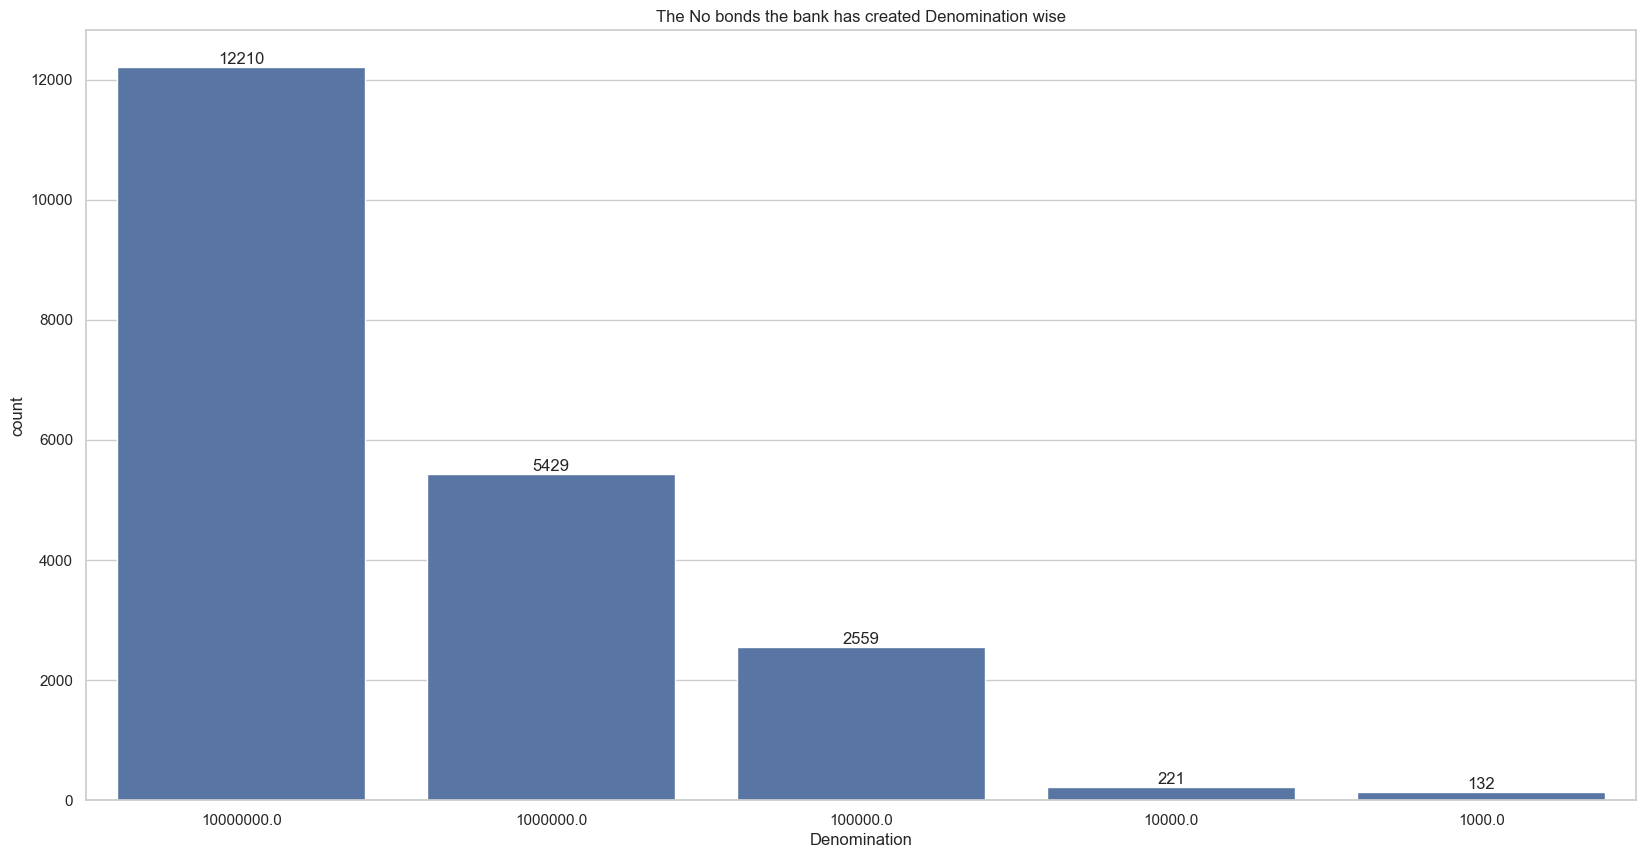

In [238]:
# Set the figure size
plt.figure(figsize=(20, 10))
# Calculate value counts of 'Denomination' and sort by descending order of counts
denomination_counts = alldata_df['Denomination'].value_counts().sort_values(ascending=False)
# Create the count plot with specified order and add count labels
ax = sns.countplot(data=alldata_df, x='Denomination', order=denomination_counts.index)
ax.bar_label(ax.containers[0])  # Add count labels to the bars
# title 
plt.title("The No bonds the bank has created Denomination wise")
# Show the plot
plt.show()

- By this graph we know that the calculate value  count of Denominations. 
-  The no.of bonds taken by the Donor according to Denominations which are created by the banks

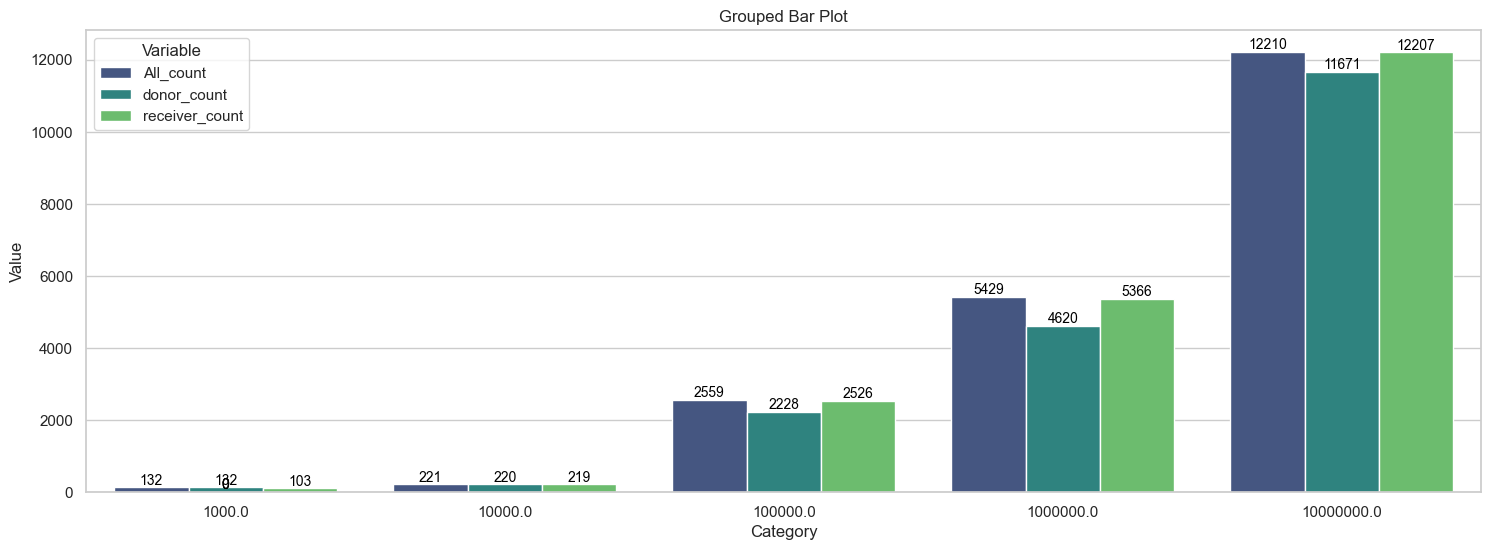

In [239]:
# Plotting
plt.figure(figsize=(18, 6))  # Set the figure size

# Melt the DataFrame to convert it to the long format
append_denominations_count_melted = append_denominations_count.reset_index().melt(id_vars='Denomination', 
                                                                                  var_name='Variable', 
                                                                                  value_name='Value')

# Create the grouped bar plot using Seaborn
ax = sns.barplot(x='Denomination', y='Value', hue='Variable', data=append_denominations_count_melted, palette='viridis')

# Adding numerical labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Adding title and labels
plt.title('Grouped Bar Plot')
plt.xlabel('Category')
plt.ylabel('Value')

# Show plot
plt.show()

In [240]:
append_denominations_count = append_denominations_count.reset_index()
append_denominations_count

,Denomination,All_count,donor_count,receiver_count
0,10000000.0,12210,11671,12207
1,1000000.0,5429,4620,5366
2,100000.0,2559,2228,2526
3,10000.0,221,220,219
4,1000.0,132,132,103


In [241]:
append_denominations_count.columns

Index(['Denomination', 'All_count', 'donor_count', 'receiver_count'], dtype='object')

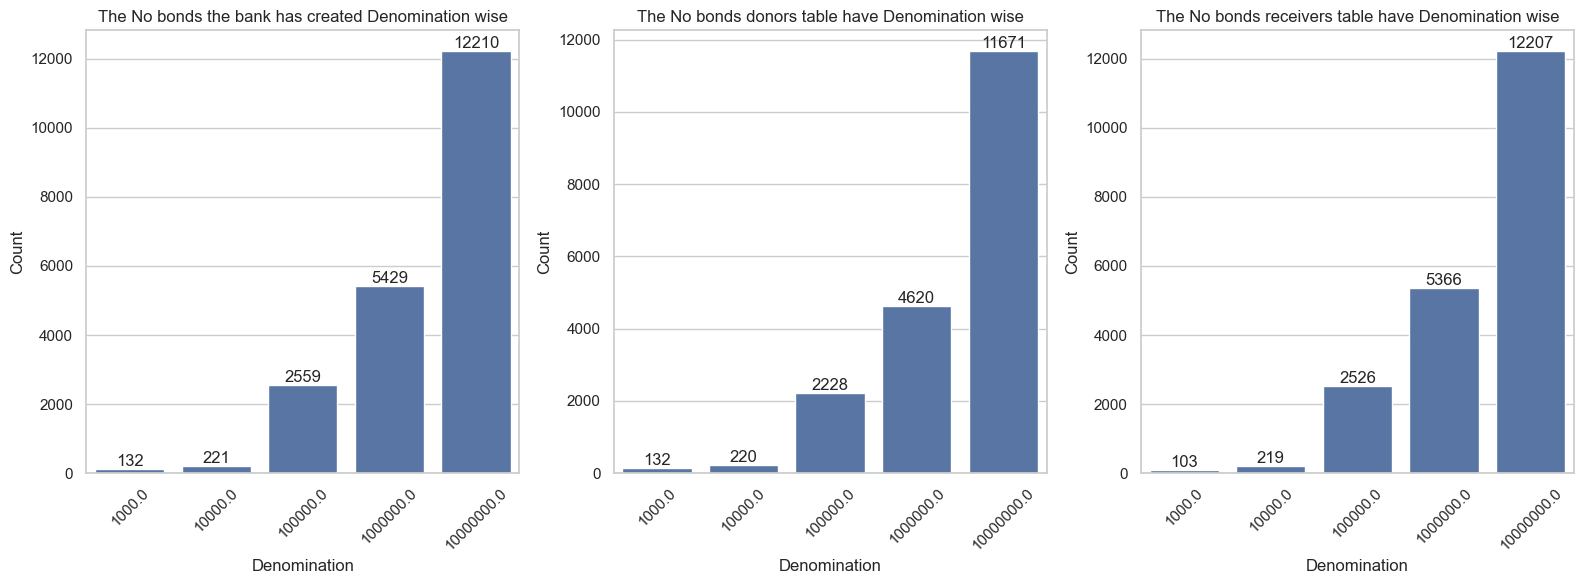

In [242]:
# Set the figure size (larger figure)
plt.figure(figsize=(16, 6))

# Plot the first count plot (leftmost)
plt.subplot(1, 3, 1)
sns.barplot(data=append_denominations_count, x='Denomination', y='All_count')
plt.title('First Plot')
plt.xlabel('Denomination')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("The No bonds the bank has created Denomination wise")
plt.gca().bar_label(plt.gca().containers[0])  # Add count labels to the bars

# Plot the second count plot (middle)
plt.subplot(1, 3, 2)
sns.barplot(data=append_denominations_count, x='Denomination', y='donor_count')
plt.title('Second Plot')
plt.xlabel('Denomination')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("The No bonds donors table have Denomination wise")
plt.gca().bar_label(plt.gca().containers[0])  # Add count labels to the bars

# Plot the third count plot (rightmost)
plt.subplot(1, 3, 3)
sns.barplot(data=append_denominations_count, x='Denomination', y='receiver_count')
plt.title('Third Plot')
plt.xlabel('Denomination')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("The No bonds receivers table have Denomination wise")
plt.gca().bar_label(plt.gca().containers[0])  # Add count labels to the bars

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

- The no.of bonds created by the banks as Denominations wise and we are comparing bank, donor, receiver Denominations.
- The no.of bonds received to the donor from the banks and the no.of bond donated  by the Donor to the Receiver.
- 


## Bond Prefix Count Distribution 

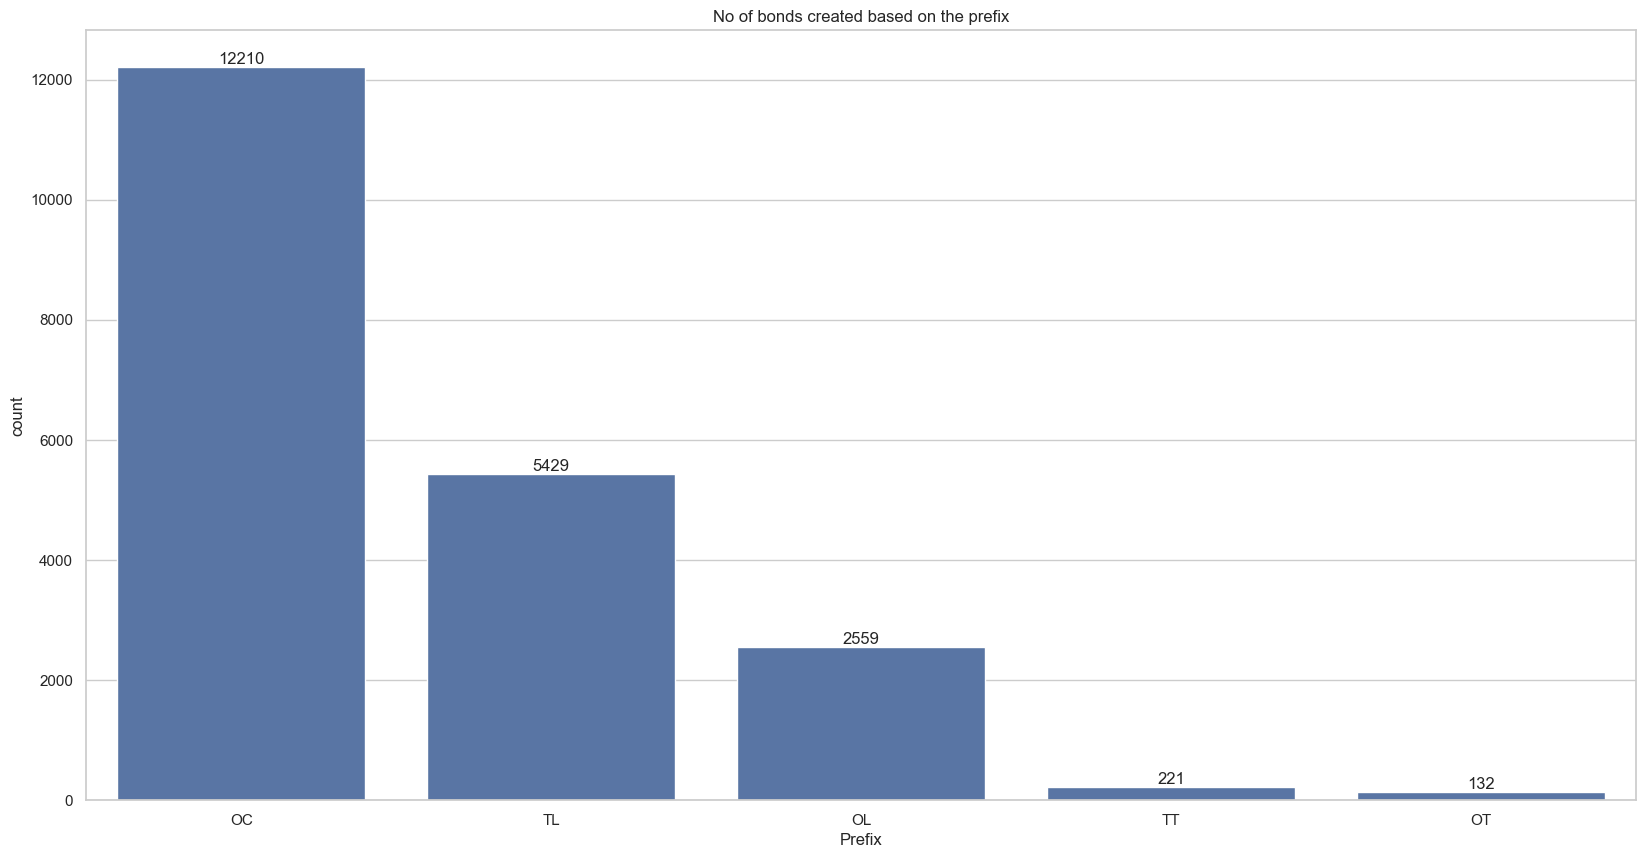

In [247]:
# Assuming you have a DataFrame named 'alldata_df' and want to plot a count plot for 'Prefix'
plt.figure(figsize=(20, 10))  # Set the figure size (width, height) in inches
# Calculate value counts of 'Prefix' and sort by descending order of counts
prefix_counts = alldata_df['Prefix'].value_counts().sort_values(ascending=False)
# Create the count plot using Seaborn with specified order
ax = sns.countplot(data=alldata_df, x='Prefix', order=prefix_counts.index)
# Add count labels to the bars
ax.bar_label(ax.containers[0])  # Assuming you want to label the first container
# Rotate x-axis labels by -45 degrees for better readability
plt.xticks(rotation=0)
plt.title("No of bonds created based on the prefix")
# Show the plot
plt.show()

- In this graph we have data 'alldata_df' in this we calculate the count of 'prefix' to know the no.of bonds created based on the 'prefix'.

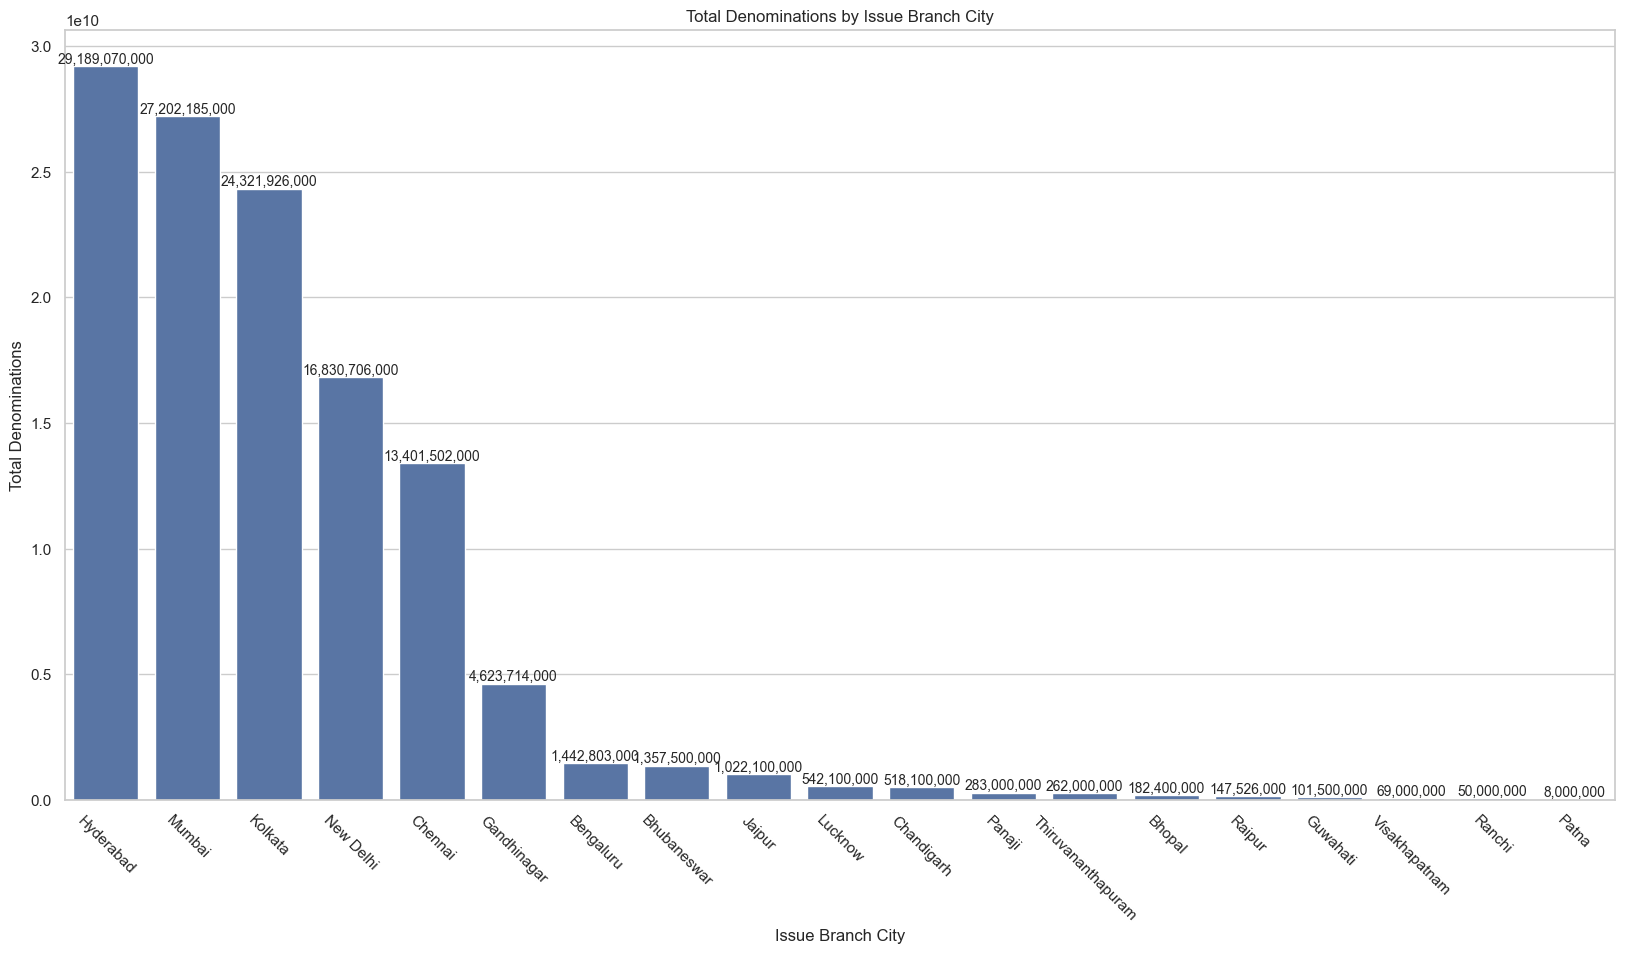

In [248]:
# Aggregate sum of 'Denomination' by 'IssueBranchCity'
city_sum_denominations = alldata_df.groupby('IssueBranchCity')['Denomination'].sum()

# Sort the aggregated sums in descending order
city_sum_denominations = city_sum_denominations.sort_values(ascending=False)

# Create a count plot based on the aggregated sums
plt.figure(figsize=(20, 10))  # Set the figure size (width, height) in inches
ax = sns.barplot(x=city_sum_denominations.index, y=city_sum_denominations.values, order=city_sum_denominations.index)

# Add count labels (sums of denominations) to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Rotate x-axis labels by -45 degrees for better readability
plt.xticks(rotation=-45)
plt.xlabel('Issue Branch City')
plt.ylabel('Total Denominations')
plt.title('Total Denominations by Issue Branch City')
plt.show()

- In this graph we know that the aggregate sum of 'Denominations' by  'Issue Branch City'.
- The total Denominations issue by each  Branch City and Hyderabad branch city issue more no.of Denominations.

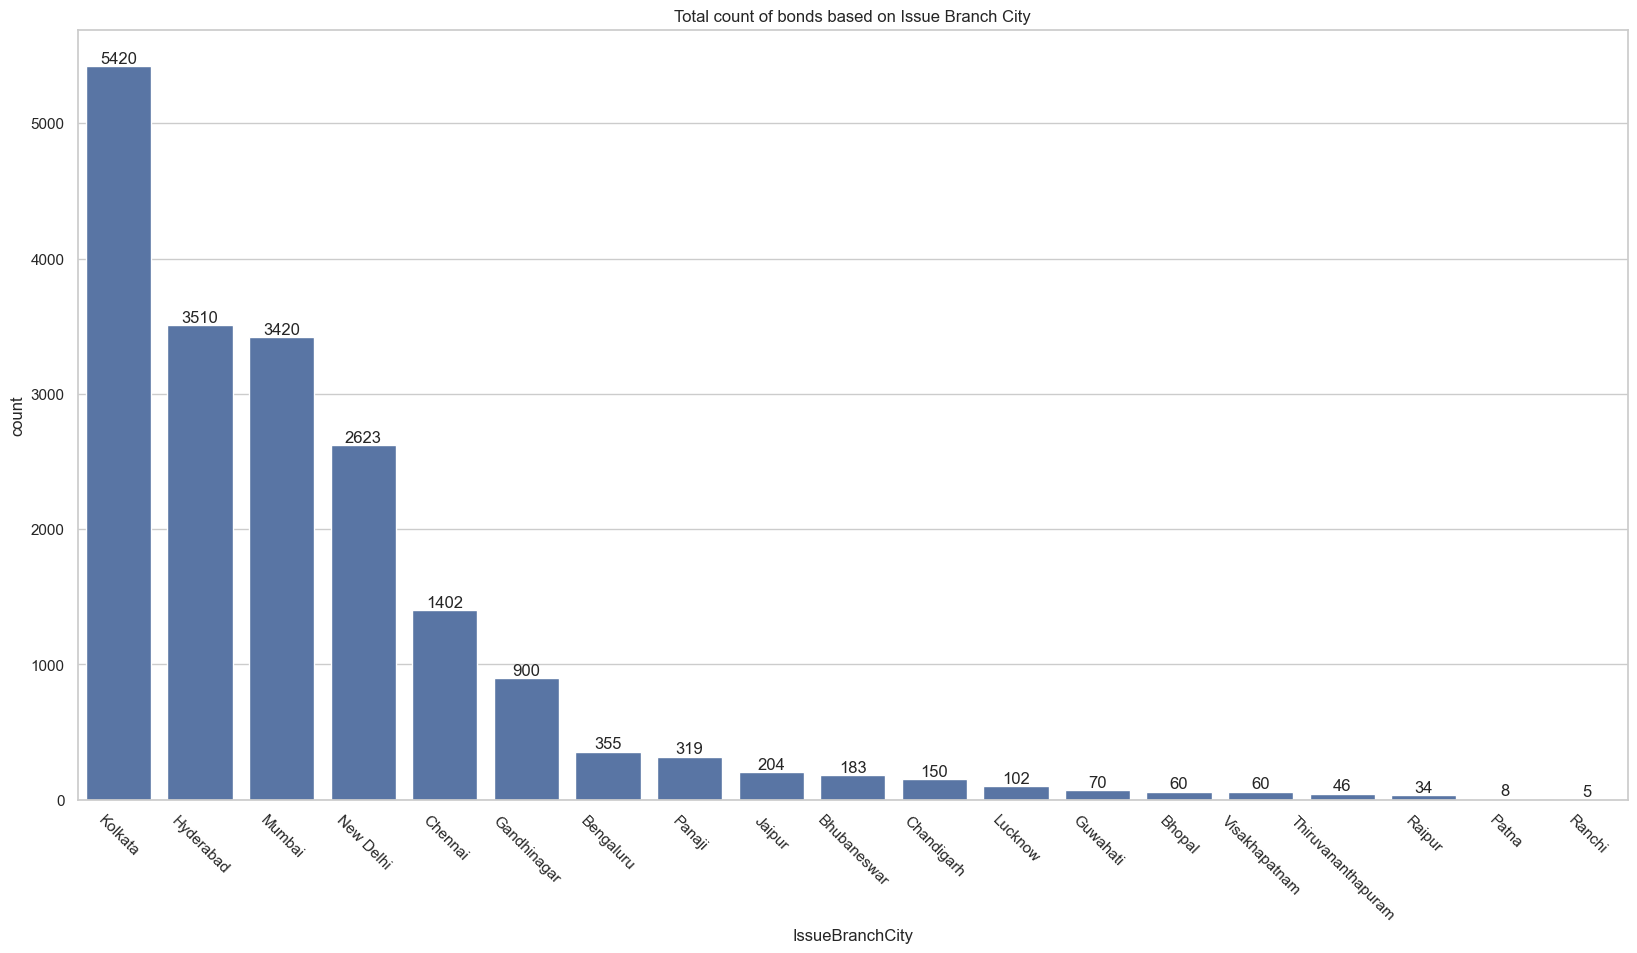

In [249]:
# Assuming you have a DataFrame named 'alldata_df' and want to plot a count plot
plt.figure(figsize=(20, 10))  # Set the figure size (width, height) in inches
# Calculate value counts of 'IssueBranchCity' and sort by descending order of counts
city_counts = alldata_df['IssueBranchCity'].value_counts().sort_values(ascending=False)
# Create the count plot using Seaborn with specified order
ax = sns.countplot(data=alldata_df, x='IssueBranchCity', order=city_counts.index)
# Add count labels to the bars
ax.bar_label(ax.containers[0])  # Assuming you want to label the first container
# Rotate x-axis labels by -45 degrees for better readability
plt.xticks(rotation=-45)
plt.title('Total count of bonds based on Issue Branch City')
# Show the plot
plt.show()